### Preparation

In [296]:
import pandas as pd
import numpy as np
import json 
import math
import statistics
import seaborn as sns
import pprint as p
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm
import plotly
import plotly.express as px
import plotly.graph_objs as go
import warnings
import kaleido
from sklearn.cluster import KMeans 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score
from colour import Color
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from io import StringIO
from pandas.errors import ParserError
from plotly.subplots import make_subplots
from scipy.stats import ttest_ind
from scipy.stats import levene
from scipy.stats import mannwhitneyu

# you need to install kaleido. On conda environment:  conda install python-kaleido

from matplotlib_venn import venn2
from pandas.plotting import parallel_coordinates
from matplotlib import rcParams
from functions import *
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from sklearn.feature_selection import mutual_info_classif

csfont = {'fontname':'Times New Roman'}
hfont = {'fontname':'Helvetica'}
prop = fm.FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf')
mpl.rc('font',family='Times New Roman')
class color:
   PURPLE, CYAN, DARKCYAN, BLUE = '\033[95m', '\033[96m', '\033[36m', '\033[94m'
   GREEN, YELLOW, RED, BOLD = '\033[92m', '\033[93m', '\033[91m','\033[1m'
   UNDERLINE, END = '\033[4m','\033[0m'
warnings.simplefilter(action='ignore', category=FutureWarning)

In [297]:
df = pd.read_csv('CleanData/HSS_lf.csv', sep=';')
q_data = pd.read_csv('CleanData/Q_df.csv', sep=';')
customization_data = pd.read_csv('CleanData/Customization.csv', sep=';')
q_data = q_data.drop(columns='Unnamed: 0')
q_data = q_data.drop_duplicates(subset='UserID', keep='last')

In [298]:
df = df.iloc[:, ~df.columns.isin(customization_data.iloc[:,2:].columns)].iloc[:, 1:]
df.columns.tolist()

['UserID',
 'safety',
 'totalAnnotatedDialogues',
 'totalAnnotatedGraffiti',
 'storyProgress',
 'playerPos',
 'rotation',
 'level',
 'crystals',
 'battery',
 'exp',
 'maxexp',
 'soap',
 'rocket',
 'glider',
 'dialogueIndex',
 'graffitiTutorial',
 'dialogueTutorial',
 'annotatedGraffitiIndeces',
 'saveableObjects',
 'friends',
 'dialoguesFinished',
 'graffitiFinished',
 'likes',
 'annData',
 'GameTime',
 'GraffitiTime',
 'DialogueTime',
 'NumberOfGraffitiActivated',
 'NumberOfAnnotatedGraffiti',
 'NumberOfDialoguesActivated',
 'NumberOfAnnotatedSentences']

#####  Users identified between HSS data and questionnaire data

In [299]:
df = df.drop_duplicates(subset='UserID', keep='last')

HSS sample of users: 428
Questionnaire sample of users: 358


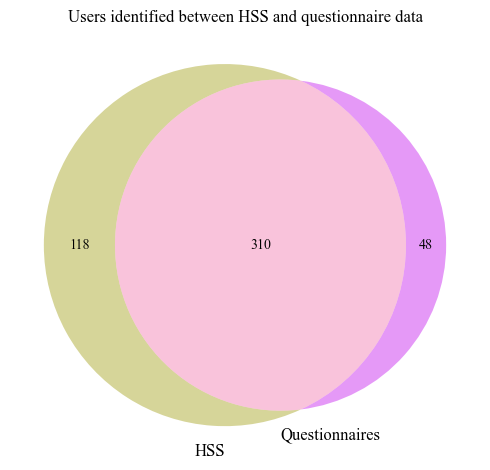

Only users with questionnaire data will be considered for this analysis.


In [300]:
print(f"HSS sample of users: {df.UserID.unique().shape[0]}")
print(f"Questionnaire sample of users: {q_data.UserID.unique().shape[0]}")
figure, ax = plt.subplots(1, 1, figsize=[5, 5])
set1 = set(df.UserID.tolist())
set2 = set(q_data.UserID.tolist())
venn_labels = {'10': f'Total Set 1: {len(set1)}', '01': f'Total Set 2: {len(set2)}'} 
venn2(subsets=(len(set1 - set2), len(set2 - set1), len(set1.intersection(set2))),
      set_labels=('HSS', 'Questionnaires'), set_colors=('#999600', '#be00ed'))
plt.tight_layout()
plt.title('Users identified between HSS and questionnaire data')
plt.savefig("Graphs/venndiagram.pdf", dpi=1000)
plt.show()
print('Only users with questionnaire data will be considered for this analysis.')
df = df[df.UserID.isin(set1.intersection(set2))]
q_data = q_data[q_data.UserID.isin(set1.intersection(set2))]

In [301]:
df.describe().iloc[1:,:12]

,safety,totalAnnotatedDialogues,totalAnnotatedGraffiti,storyProgress,level,crystals,battery,exp,maxexp,soap,dialogueIndex,friends
mean,443.213320,9.348387,5.029032,0.080645,1.683871,59.848387,3.929032,48.874194,114.170968,50.335484,8.238710,0.829032
std,269.951748,14.171668,3.740247,0.272730,1.124915,48.505559,2.783701,47.392873,55.572104,34.124136,10.342099,1.160207
min,6.256084,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000
25%,229.382000,1.000000,2.000000,0.000000,1.000000,22.000000,1.000000,16.250000,100.000000,21.000000,1.000000,0.000000
50%,388.326920,6.000000,4.000000,0.000000,1.000000,50.000000,5.000000,41.000000,100.000000,50.500000,5.500000,0.000000
75%,596.512405,11.000000,7.000000,0.000000,2.000000,89.000000,7.000000,78.750000,108.000000,78.000000,11.000000,2.000000
max,1000.000000,129.000000,22.000000,1.000000,9.000000,274.000000,7.000000,566.000000,829.000000,100.000000,75.000000,7.000000


In [12]:
df.describe().iloc[1:,12:]

,likes,GameTime,GraffitiTime,DialogueTime,NumberOfGraffitiActivated,NumberOfAnnotatedGraffiti,NumberOfDialoguesActivated,NumberOfAnnotatedSentences
mean,124.338710,943.227738,589.418492,580.827603,9.419355,7.458065,18.835484,9.348387
std,194.989714,370.937470,509.632637,908.858772,7.559791,6.102404,16.776719,14.171668
min,0.000000,15.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,723.716278,283.453827,167.090752,4.000000,3.000000,8.000000,1.000000
50%,83.000000,904.639465,445.622513,333.637039,8.000000,6.000000,15.000000,6.000000
75%,161.500000,1137.298950,760.664612,679.939301,12.000000,10.000000,25.750000,11.000000
max,2449.000000,2388.364258,3457.448486,9566.537109,66.000000,40.000000,144.000000,129.000000


In [13]:
print(df.dtypes.sort_values())

dialogueTutorial                 bool
graffitiTutorial                 bool
glider                           bool
rocket                           bool
dialogueIndex                   int64
NumberOfAnnotatedGraffiti       int64
NumberOfGraffitiActivated       int64
NumberOfDialoguesActivated      int64
battery                         int64
NumberOfAnnotatedSentences      int64
totalAnnotatedDialogues         int64
level                           int64
storyProgress                   int64
totalAnnotatedGraffiti          int64
crystals                        int64
exp                           float64
safety                        float64
DialogueTime                  float64
GraffitiTime                  float64
GameTime                      float64
likes                         float64
friends                       float64
soap                          float64
maxexp                        float64
graffitiFinished               object
saveableObjects                object
annData     

# The Typical Gameplay
In this section I try to describe the typical behaviour. It is broken down into: 

- some data preparation (computing time spent on some actions, cleaning nan values)
- clustering and interpretation

In [14]:
df['annData'].iloc[0]

'{"id":{"0":1740,"1":1752,"2":2241,"3":2241,"4":2241},"timePerToken":{"0":1.4626874924,"1":1.2555999756,"2":2.7152500153,"3":0.4467499852,"4":0.8592500091},"type":{"0":"dialogue","1":"dialogue","2":"graffiti","3":"graffiti","4":"graffiti"}}'

In [303]:
Dialogue_avgt = []
Graffiti_avgt = []

c = 0
for i in range(df.shape[0]):
    
    s = df['annData'].iloc[i]
    
    if str(s) == 'nan':  
        #insert in list the average time spent for the user who is indexed, distinguishing between dialogue and graffiti
        Dialogue_avgt.append(0)
        Graffiti_avgt.append(0)
        c += 1
        continue
    
    small_df = pd.read_json(s)
    
    if small_df.empty or df['DialogueTime'].iloc[i] == 0:   #when the dataframe is empty or nan we can replace with 0
        c+=1
        Dialogue_avgt.append(0)
        Graffiti_avgt.append(0)
        
    else:  
        m1, m2 = small_df[small_df.type == 'dialogue'].timePerToken.mean(), small_df[small_df.type == 'graffiti'].timePerToken.mean()
        
        Dialogue_avgt.append(zero(m1))
        Graffiti_avgt.append(zero(m2))
    
    
df['Dialogue_avgt'] = Dialogue_avgt
df['Graffiti_avgt'] = Graffiti_avgt

print(f'Empty annData: {c}')
df.isnull().sum()  #this displays the counts if the operation produced any nan values (which can occur with .mean() when there are no values). We know there are already 10 from data collection.

Empty annData: 25


UserID                          0
safety                          0
totalAnnotatedDialogues         0
totalAnnotatedGraffiti          0
storyProgress                   0
playerPos                       0
rotation                        0
level                           0
crystals                        0
battery                         0
exp                             0
maxexp                          0
soap                            0
rocket                          0
glider                          0
dialogueIndex                   0
graffitiTutorial                0
dialogueTutorial                0
annotatedGraffitiIndeces        0
saveableObjects               196
friends                         0
dialoguesFinished               0
graffitiFinished                0
likes                           0
annData                        10
GameTime                        0
GraffitiTime                    0
DialogueTime                    0
NumberOfGraffitiActivated       0
NumberOfAnnota

In [16]:
df['annData'] = [pd.read_json(l) if not str(l) == 'nan' else np.nan for l in df.annData]
df['saveableObjects'] =  [pd.read_json(l) if not str(l) == 'nan' else np.nan for l in df.saveableObjects]

In [321]:
q_data.Gender = ['Preferisco non rispondere' if str(i) == 'nan' else i for i in q_data.Gender]

#### Mean vs Median for time spent on graffiti and dialogues
In this small subsection I will check if the mean a comparable summary statistic to represent the time spent of removing graffiti and the time spent in dialogues. To answer, I visually inspect the regularized distribution (the averages of all users actions) with the original distribution.  

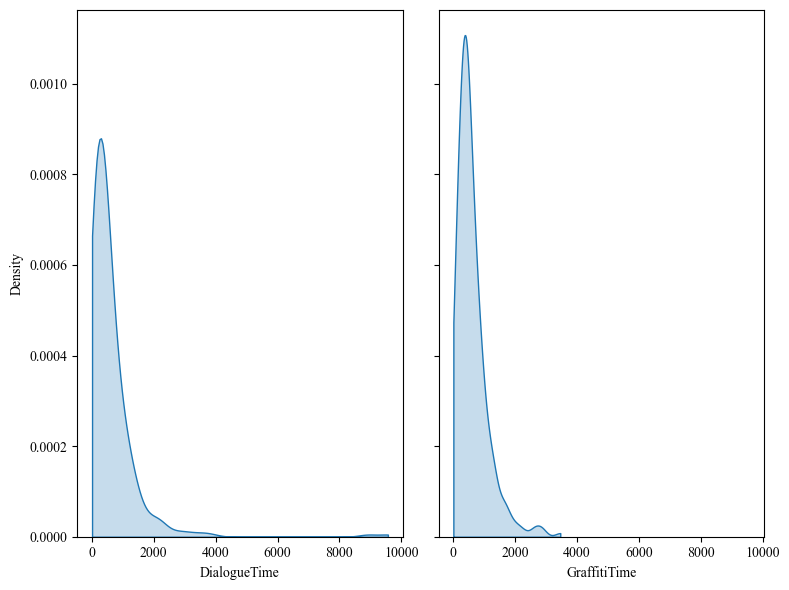

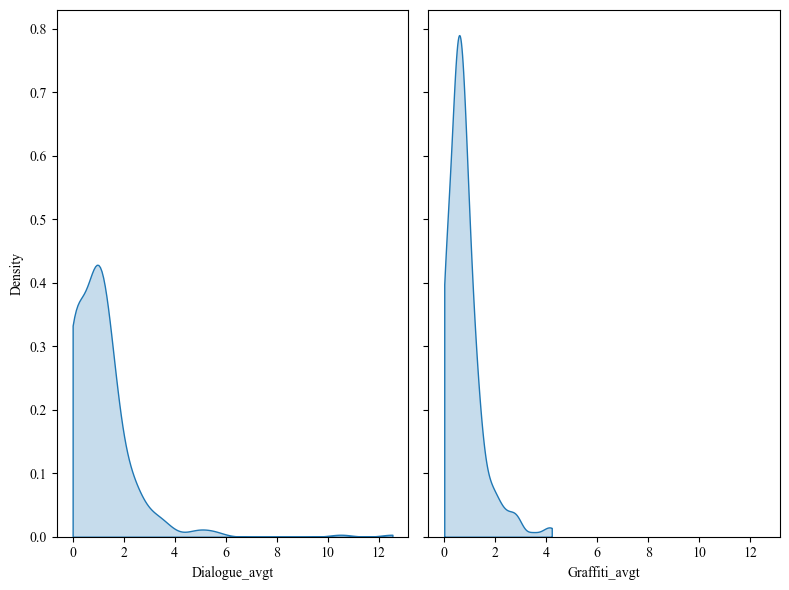

In [322]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharey=True, sharex=True) 
sns.kdeplot(df.DialogueTime, cut=0, fill=True, ax=axs[0])
sns.kdeplot(df.GraffitiTime, cut=0, fill=True, ax=axs[1])
plt.tight_layout()
fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharey=True, sharex=True) 
sns.kdeplot(df.Dialogue_avgt, cut=0, fill=True, ax=axs[0])
sns.kdeplot(df.Graffiti_avgt, cut=0, fill=True, ax=axs[1])
plt.tight_layout()
plt.show()

It appears that the shape of the distributions is relatively intact but scaled to the right dimension. It also seems to skew less to the right, which is what is needed as many outliers are present. As a final comparison, below you can visually inspect the mean vs median, but it doesn't seem to differ much. 

In [323]:
# Dialogue_avgt = []
# Graffiti_avgt = []
# for user in range(df.shape[0]):
#     try:
#         Dialogue_avgt.append(df.iloc[user].annData[df.iloc[user].annData.type=='dialogue'].timePerToken.median())
#         Graffiti_avgt.append(df.iloc[user].annData[df.iloc[user].annData.type=='graffiti'].timePerToken.median())
#     except AttributeError:
#         Dialogue_avgt.append(0)
#         Graffiti_avgt.append(0)
# df['Dialogue_avgt'] = Dialogue_avgt
# df['Graffiti_avgt'] = Graffiti_avgt

# fig, axs = plt.subplots(2, 2, figsize=(8, 6)) 

# sns.kdeplot(df.Dialogue_avgt, cut=0, fill=True, ax=axs[0, 0])
# sns.kdeplot(df.Graffiti_avgt, cut=0, fill=True, ax=axs[0, 1])
# sns.kdeplot(df.DialogueTime, cut=0, fill=True, ax=axs[1, 0])
# sns.kdeplot(df.GraffitiTime, cut=0, fill=True, ax=axs[1, 1])
# plt.tight_layout()
# plt.show()

In [326]:
g_data = pd.DataFrame({'Dialogue_avgt':df.Dialogue_avgt.tolist(), 'Graffiti_avgt':df.Graffiti_avgt, 'DialogueTime':df.DialogueTime})
g_data['Gender'] = [gender if "Preferisco non rispondere" else 'NA' for gender in q_data.Gender]
print(g_data.Gender.value_counts())
g_data['Age'] = [age for age in q_data['Age']]

Gender
Maschio                      177
Femmina                      110
Preferisco non rispondere     23
Name: count, dtype: int64


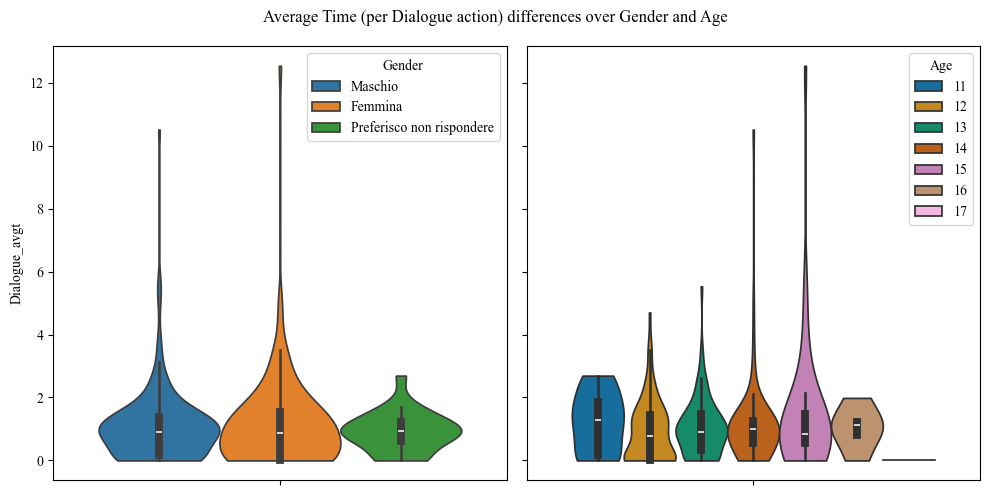

In [328]:
fig, axs = plt.subplots(1,2, figsize=(10, 5), sharey= True, sharex=True) 
sns.violinplot(data=g_data, y='Dialogue_avgt', cut=0, fill=True, hue = 'Gender', ax=axs[0])
sns.violinplot(data=g_data, y='Dialogue_avgt', cut=0, fill=True, hue='Age', ax=axs[1], palette=sns.color_palette('colorblind', 7))
plt.suptitle('Average Time (per Dialogue action) differences over Gender and Age')
plt.tight_layout()
plt.savefig('Graphs/Violinplots_DialogueTime_on_Gender_Age.png', dpi=500)
plt.show()

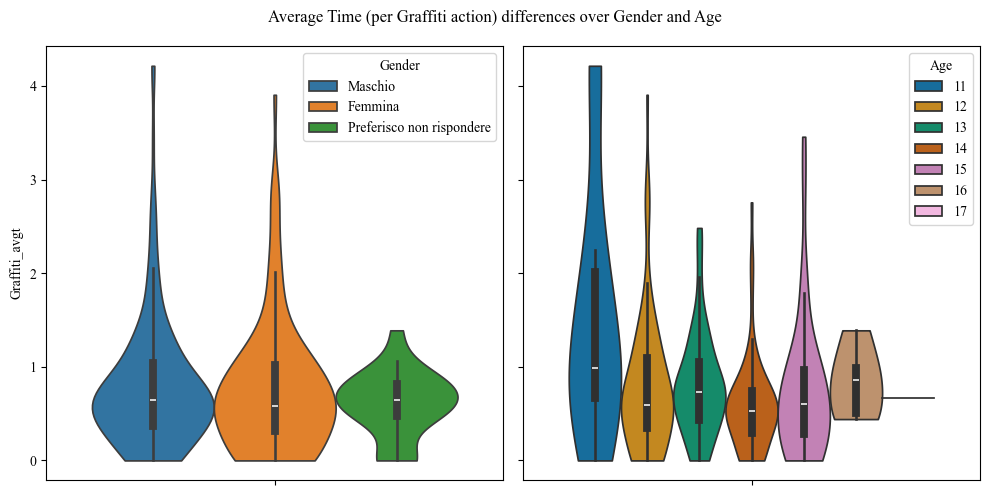

In [329]:
fig, axs = plt.subplots(1,2, figsize=(10, 5), sharey= True, sharex=True) 
sns.violinplot(data=g_data, y='Graffiti_avgt', cut=0, fill=True, hue = 'Gender', ax=axs[0])
sns.violinplot(data=g_data, y='Graffiti_avgt', cut=0, fill=True, hue= 'Age', ax=axs[1], palette=sns.color_palette('colorblind', 7))
plt.suptitle('Average Time (per Graffiti action) differences over Gender and Age')
plt.tight_layout()
plt.show()

In [330]:
df.friends.value_counts().sort_index()

friends
0.0    175
1.0     53
2.0     56
3.0     18
4.0      5
5.0      1
6.0      1
7.0      1
Name: count, dtype: int64

In [331]:
df.to_csv('HSS_for_FB.csv', sep=';') #checkpoint

#### Sequential pattern mining
This is more experimental. 

In [332]:
from prefixspan import PrefixSpan

In [338]:
l_pat = []
# this loop takes each small dataframe in annData and puts the actions into a list for each user
for l in df.annData:
    if str(l) == 'nan':
        l_pat.append([])
        continue
    l_pat.append(l.type.values)

ps = PrefixSpan(l_pat)
patterns = ps.topk(10) 
#the patterns of  will be printed out in order of presence.
for pattern in patterns:
     
    print(f"Pattern: {pattern[1]}, Support: {pattern[0]}")

AttributeError: 'str' object has no attribute 'type'

In [334]:
l_pat = []
#this loop takes each small dataframe in saveable objects [...] for each user
for dataframe in range(df.saveableObjects.shape[0]):
    try: 
        l = df.saveableObjects.iloc[dataframe].name.tolist()
    except AttributeError:
        l = []
    l_pat.append(l)
ps = PrefixSpan(l_pat)
patterns = ps.topk(5)

for pattern in patterns:
    print(f"Pattern: {pattern[1]}, Support: {pattern[0]}")

#### Features to exclude
Some features of HSS, as programmed by Federico Bonetti, are not useful for any behavioural analysis and must be removed to avoid confusion while interpreting or spurious correlations. 
The construction of the game is not documented by design in "shareable" terms to outsiders, so me and Federico Bonetti compiled a small documentation of the features (contained in "Documentazioni variabili.odt"). 
The criteria for exluding a variable comprise of: 

1. The variable is only useful for the system to keep track of a user's progress in case of loss and / or may be always constant in the data [_storyProgress_, _dialoguesFinished_, _graffitiFinished_, _dialogue_index_, _graffitiTutorial_, _maxSoap_, _maxexp_];
2. The variable can lower its value during the gameplay, and since the data we possess is not dynamic (instead of, for example, time-series data) but static (metaphorically, a screenshot of the last thing a user saw + backend variables), it does not represent any phenomena clearly [_Battery_, _Crystals_, _Soap_, _Safety_] and may also fit in criteria n.3;
3. The variable is necessary for another one to be leveled up [_NumberOfGraffitiActivated_ , some others based on their correlation values].

**Procedure**: following the order of the criteria (1, then 2, then 3), I remove the features we have deemed as immediately unuseful, then using a mix of threshold of correlation and understanding of the variable's nature we remove variables that fit the criteria number 3. 
As an exception, some variables are simply too important even though they are heavily correlated with other, because they represent slightly different in game choices and behaviours. One of these is "level"; level is highly correlated with anything that levels the gamer up, but what matters is how the player leveled up  which can be done in several ways. 

Another one is the pair "totalAnnotatedGraffiti" and "NumberOfGraffitiActivated". These are similar, but one may indicate a more precise behaviour of erasing graffiti and the other simply removing any portion of the graffito. Instead, "totalAnnotatedDialogues" and "NumberOfAnnotatedSentences" are identical, hence we can remove one. 

In [339]:
cols = ['level', 'exp', 
        'rocket', 'glider', 
        'friends', 'likes', 
        'GameTime', 
        'NumberOfAnnotatedGraffiti', 'totalAnnotatedGraffiti', 'Graffiti_avgt',
        'NumberOfDialoguesActivated', 'totalAnnotatedDialogues', 'Dialogue_avgt']

In [340]:
numerical = []

for col in df.columns.sort_values().to_list():
    if type(df[col].iloc[50]) == type('im a string value'):
        continue
    numerical.append(col)

In [341]:
#in case you want to see a fuller matrix
numerical = [
 'DialogueTime',
 'Dialogue_avgt',
 'GameTime',
 'GraffitiTime',
 'Graffiti_avgt',
 'NumberOfAnnotatedGraffiti',
 'NumberOfAnnotatedSentences',
 'NumberOfDialoguesActivated',
 'NumberOfGraffitiActivated',
 'battery',
 'crystals',
 'dialogueIndex',
 'dialogueTutorial',
 'dialoguesFinished',
 'exp',
 'friends',
 'glider',
 'graffitiFinished',
 'graffitiTutorial',
 'level',
 'likes',
 'rocket',
 'safety',
 'totalAnnotatedGraffiti'
]

In [342]:
q_data.columns

Index(['UserID', 'Age', 'Gender', 'Education', 'FTSA1', 'FTSA2', 'FTSA3',
       'FTSA4', 'FTSA5', 'FTSA6', 'FTSC1', 'FTSC2', 'FTSC3', 'FTSC4', 'FTSC5',
       'FTSC6', 'IMI-IE1', 'IMI-IE2', 'IMI-IE3', 'IMI-IE4', 'IMI-IE5',
       'IMI-IE6', 'IMI-IE7', 'IMI-PC1', 'IMI-PC2', 'IMI-PC3', 'IMI-PC4',
       'IMI-PC5', 'IMI-PC6', 'IMI-VU1', 'IMI-VU2', 'IMI-VU3', 'IMI-VU4',
       'IMI-VU5', 'IMI-VU6', 'IMI-VU7', 'Creender', 'Creender appropriateness',
       'HSS', 'HSS appropriateness', 'RC', 'RC appropriateness',
       'General engagement', 'Relationship with researchers',
       'Recommendations'],
      dtype='object')

In [343]:
categorical = ['Age', 'Gender', 'Education',
       'General engagement']
q_ordinal_encoded = pd.read_csv('CleanData/Q_data_ordinallyencoded.csv', sep=';')

mask_uniqueIDs = q_ordinal_encoded.index.isin(q_ordinal_encoded.UserID.drop_duplicates(keep='last').index) & q_ordinal_encoded.UserID.isin(df.UserID)
q_ordinal_encoded = q_ordinal_encoded[mask_uniqueIDs]
df = df.merge(q_ordinal_encoded[['UserID'] + categorical], on='UserID', how='right')
df.shape

(310, 38)

In [344]:
df.columns

Index(['UserID', 'safety', 'totalAnnotatedDialogues', 'totalAnnotatedGraffiti',
       'storyProgress', 'playerPos', 'rotation', 'level', 'crystals',
       'battery', 'exp', 'maxexp', 'soap', 'rocket', 'glider', 'dialogueIndex',
       'graffitiTutorial', 'dialogueTutorial', 'annotatedGraffitiIndeces',
       'saveableObjects', 'friends', 'dialoguesFinished', 'graffitiFinished',
       'likes', 'annData', 'GameTime', 'GraffitiTime', 'DialogueTime',
       'NumberOfGraffitiActivated', 'NumberOfAnnotatedGraffiti',
       'NumberOfDialoguesActivated', 'NumberOfAnnotatedSentences',
       'Dialogue_avgt', 'Graffiti_avgt', 'Age', 'Gender', 'Education',
       'General engagement'],
      dtype='object')

- In _Gender_, [0] indicates [male], [1] is [Preferisco non rispondere] and [2] is [female]. 
- In _Education_, [0] indicates [medie] and [1] is [superiori]. 
- In _General engagement_, in the following order, [4, 3, 2, 1, 0] indicate [Coinvolgente, Piuttosto coinvolgente, Molto coinvolgente, Poco coinvolgente, Per nulla coinvolgente]

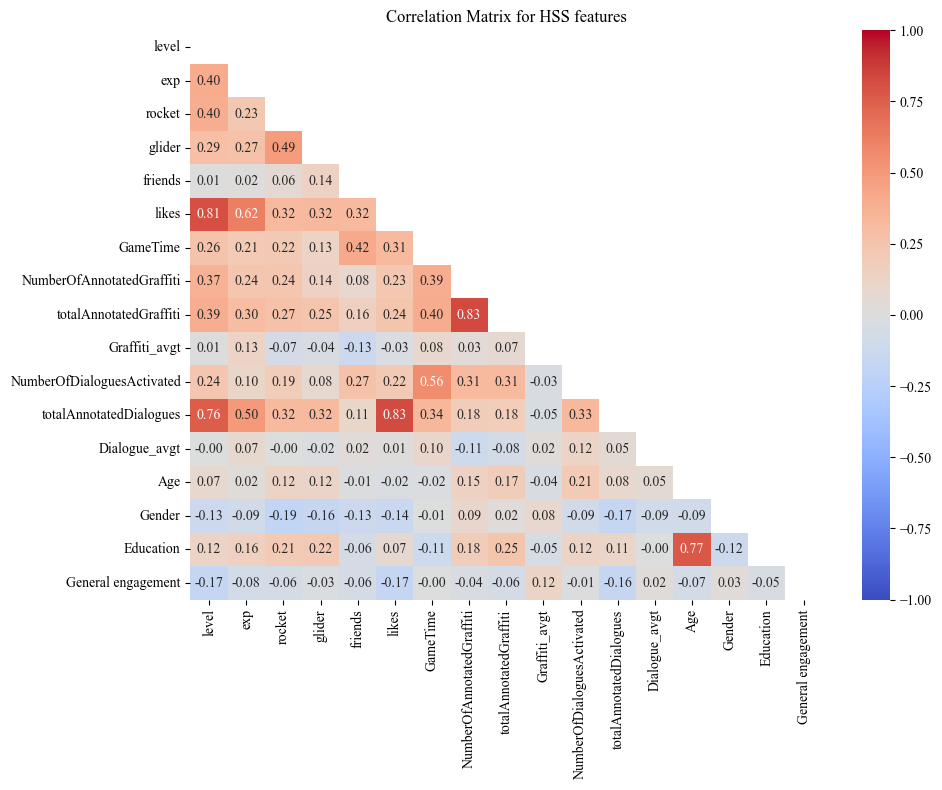

In [345]:
corr_matrix = df[cols + categorical].corr()

mask = np.triu(np.ones_like(corr_matrix.sort_index(ascending=True), dtype=bool))
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix for HSS features')
plt.tight_layout()
plt.savefig('Graphs/Correlation_Matrix_for_HSS_chosenfeatures.png', dpi= 500)
plt.show()

In [346]:
for c in cols:
    print(f'Correlation: {color.BOLD}{c}{color.END} with...')
    print(corr_matrix[c][corr_matrix[c] > +0.4].sort_values(ascending=False).iloc[1:])
    print(corr_matrix[c][corr_matrix[c] < -0.05].sort_values(ascending=False).iloc[1:])
    print()

Correlation: level with...
likes                      0.805601
totalAnnotatedDialogues    0.759866
exp                        0.400497
Name: level, dtype: float64
General engagement   -0.168551
Name: level, dtype: float64

Correlation: exp with...
likes                      0.617727
totalAnnotatedDialogues    0.495195
level                      0.400497
Name: exp, dtype: float64
Gender   -0.089468
Name: exp, dtype: float64

Correlation: rocket with...
glider    0.485451
Name: rocket, dtype: float64
Graffiti_avgt   -0.065192
Gender          -0.185875
Name: rocket, dtype: float64

Correlation: glider with...
rocket    0.485451
Name: glider, dtype: float64
Series([], Name: glider, dtype: float64)

Correlation: friends with...
GameTime    0.417405
Name: friends, dtype: float64
General engagement   -0.060969
Gender               -0.126100
Graffiti_avgt        -0.129711
Name: friends, dtype: float64

Correlation: likes with...
totalAnnotatedDialogues    0.825297
level                      0.

In [347]:
df.shape#dtypes.sort_values()

(310, 38)

#### Sub-research: the "bug-finders"
There are a few ways to play the High School Superhero videogame to level up faster. One of them is a specific way to play the dialogue option, and the other is analogous to erasing graffiti. 
During data collection, I was physically present for one session, and I noticed this while observing that some users, while playing, identified a way to play faster through spamming the dialogue option buttons, which would augment the school safety and other stats. 

Some of them weren't probably actively looking for a bugged feature, but simply looking forward to "max" some of their in-game statistics; even then, their game experience represent a relevant category of students in this secondary analysis experiment. 

Let's find out how many of them were doing so by visualizing the distribution of dialogue and graffiti actions, comparing the amount of actions and the time spent on them.

In [348]:
df.describe().columns
df.dtypes.sort_values()

glider                           bool
dialogueTutorial                 bool
graffitiTutorial                 bool
rocket                           bool
NumberOfDialoguesActivated      int64
NumberOfAnnotatedSentences      int64
dialogueIndex                   int64
NumberOfGraffitiActivated       int64
battery                         int64
NumberOfAnnotatedGraffiti       int64
level                           int64
Age                             int64
storyProgress                   int64
totalAnnotatedGraffiti          int64
crystals                        int64
totalAnnotatedDialogues         int64
exp                           float64
DialogueTime                  float64
GraffitiTime                  float64
GameTime                      float64
safety                        float64
likes                         float64
Graffiti_avgt                 float64
friends                       float64
Education                     float64
Gender                        float64
soap        

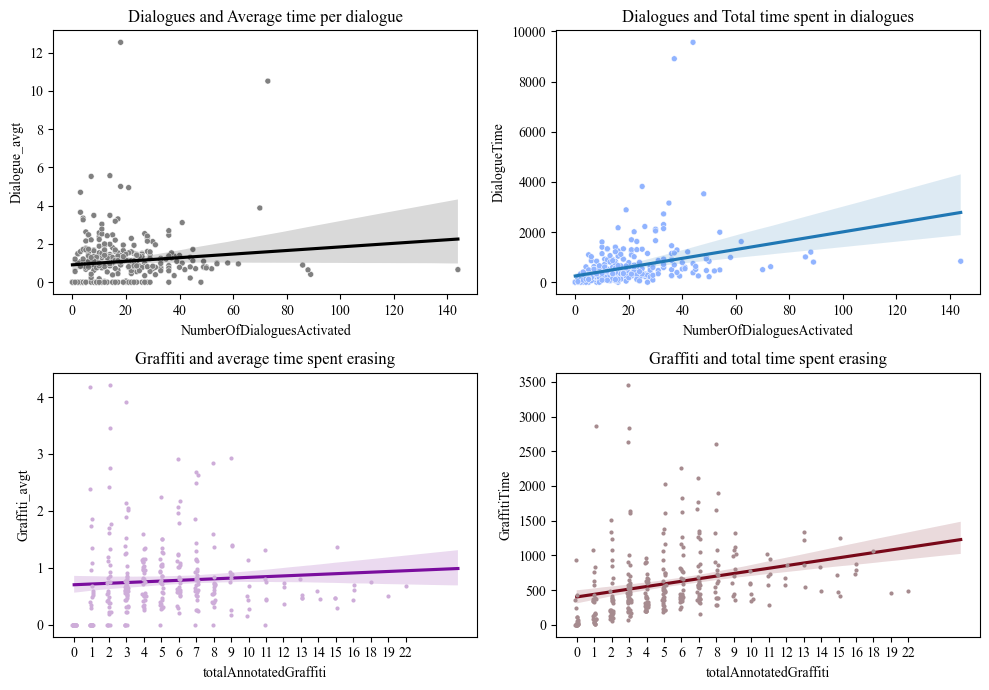

In [349]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7)) 
axs[0, 0].set_title('Dialogues and Average time per dialogue')
sns.scatterplot(data=df, x='NumberOfDialoguesActivated', y='Dialogue_avgt', ax=axs[0,0], color='grey', size=2, legend=False)
sns.regplot(data=df, x='NumberOfDialoguesActivated', y='Dialogue_avgt', ax=axs[0,0], color='black', scatter=False)

axs[0, 1].set_title('Dialogues and Total time spent in dialogues')
sns.scatterplot(data=df, x='NumberOfDialoguesActivated', y='DialogueTime', ax=axs[0, 1], color = '#91b4ff', size=2, legend=False)
sns.regplot(data=df, x='NumberOfDialoguesActivated', y='DialogueTime', ax=axs[0, 1], scatter=False)

axs[1, 0].set_title('Graffiti and average time spent erasing')
# sns.scatterplot(data=df, x='totalAnnotatedGraffiti', y='Graffiti_avgt', ax=axs[1, 0], color= '#ceadd9', size=2, legend=False, jitter=True)
sns.stripplot(data=df, x='totalAnnotatedGraffiti', y='Graffiti_avgt', ax=axs[1, 0], color= '#ceadd9', size=3, legend=False, jitter=True, edgecolor='white')
sns.regplot(data=df, x='totalAnnotatedGraffiti', y='Graffiti_avgt', ax=axs[1,0], color='#7a0d9e', scatter=False)

axs[1, 1].set_title('Graffiti and total time spent erasing')
# sns.scatterplot(data=df, x='totalAnnotatedGraffiti', y='GraffitiTime', ax=axs[1, 1], color='#a68b8f', size=2, legend=False)
sns.stripplot(data=df, x='totalAnnotatedGraffiti', y='GraffitiTime', ax=axs[1, 1], color= '#a68b8f', size=3, legend=False, jitter=True, edgecolor='white')
sns.regplot(data=df, x='totalAnnotatedGraffiti', y='GraffitiTime', ax=axs[1, 1], color='#780819', scatter=False)

plt.tight_layout()
plt.savefig('Graphs/Dialogues_and_time_BugFinders.png',dpi=500)
plt.show()

One would expect the relationship between time spent and number of dialogues activate to be somewhat linear. The more dialogues a person interacts with, the less time it can take them because they're learning how to play the game faster. On the other hand, users who don't spend much time on removing graffiti or changing dialogues, should spend more time - on average - per action. It is kind of true when we look at the average time distributions and the regression, it's a slightly negative relationship, although only slightly and **is definitely skewed by outliers**. Most users spent little time per graffiti and dialogue. 

Now I will add an environmental variable: the gender composition of the classroom a student is in. This is considered an external variable that may affect several areas of behaviour, especially during teenagehood. 
Since the variable Gender is already ordered from 0 (male) to 1 (Preferisco Non Rispondere / NA) to 2 (female), the mean is more than enough. A mean below 1 indicates a majority of males, and above 1  a majority of females. Knowing the gender distribution, the answers with "Preferisco Non Rispondere" are not too little to just delete them (for simplicity) and not enough to skew an interpretable gender distribution. 

In [350]:
classrooms = [int(s[1:4]) if s[3] != '-' else int(s[1:3]) for s in df.UserID.tolist()]
gender_env = dict()
GE = []
for c in pd.DataFrame(classrooms)[0].unique():
    mask = [s == c for s in classrooms]
    ratio = [round(df[mask].Gender.mean(), 1)]
    gender_env[c] = ratio[0]
    GE.extend(ratio*df[mask].shape[0])
df['GenderEnvironment'] = GE
gender_env

{116: 0.5,
 117: 1.3,
 155: 1.4,
 162: 0.5,
 163: 0.3,
 26: 0.8,
 43: 0.9,
 78: 0.8,
 79: 0.6,
 184: 0.6,
 185: 0.9,
 186: 0.9,
 187: 1.1,
 188: 0.9,
 189: 1.3,
 208: 0.6,
 209: 0.4,
 210: 0.4,
 211: 0.2}

Let's try to find users who stand out - in both ways, as in excelling or underperforming - with gameplay features. K means is performed separately in the kmeans script. The interpretation of the results is in this notebook.

In [351]:
df.to_csv('CleanData/HSS_kmeans.csv', sep=';')

## Clustering
Clustering is performed separately in "clustering_HSS_behaviour" notebook, as several attempts to clustering are present. To view more in depth the process please consult that notebook.

In [353]:
sclabels = pd.read_csv('scluster-master/scluster_labels.csv', sep=',', header=None)[0].tolist()

In [823]:
X1 = preprocess_data(df)[cols + categorical]  #scaled version of the data
X1['General engagement'] = pd.DataFrame(scaler.fit_transform(df[['General engagement']]))[0]

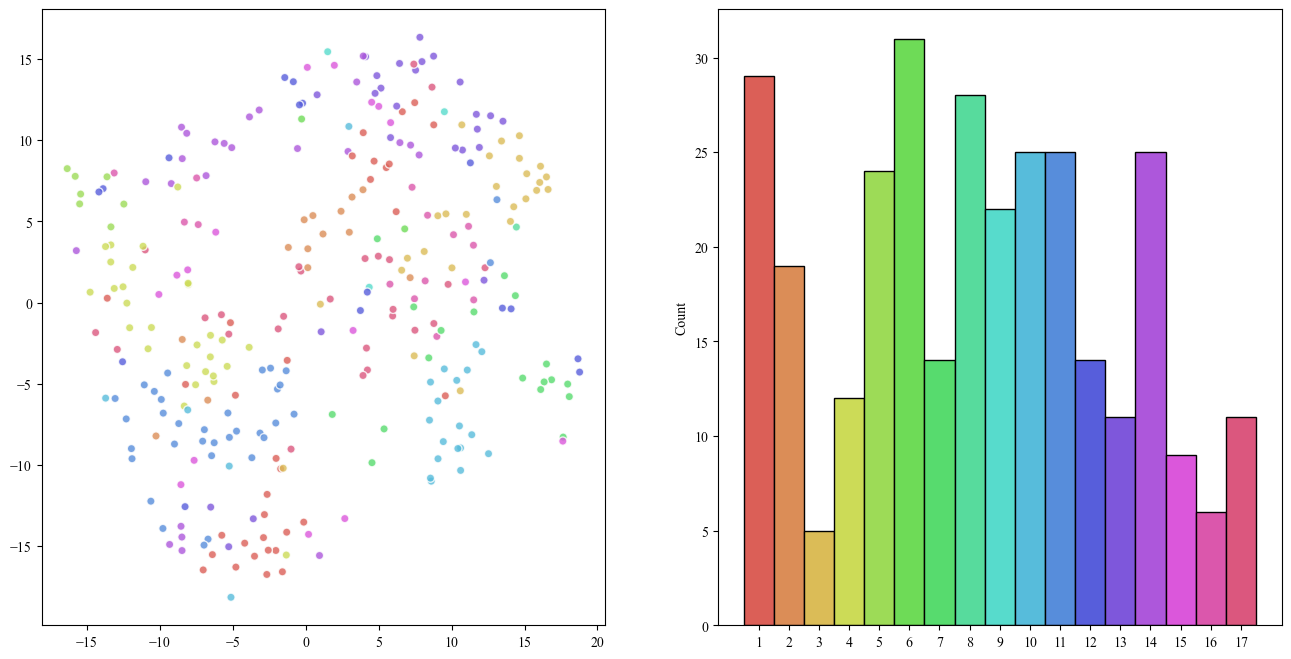

In [355]:
K = len(set(sclabels))
affinity_matrix = getAffinityMatrix(X1, k = 9)
spectralclustering = SpectralClustering(n_clusters=K,
                                        assign_labels='discretize',
                                        affinity='polynomial'
                                       ).fit_predict(X1)

fig, axs =  plt.subplots(1,2, figsize=(16, 8)) 
projection = TSNE(random_state=25).fit_transform(X1)
color_palette = sns.color_palette('hls', K)

sns.scatterplot(x=projection[:, 0], y=projection[:, 1], 
                s=35, linewidth=1, 
                color=[color_palette[x] for x in spectralclustering], 
                alpha=0.8, ax=axs[0], legend='full')

sns.histplot(data=sclabels, ax=axs[1], bins=K, discrete=True, element='bars')

for patch, color in zip(axs[1].patches, color_palette):
    patch.set_facecolor(color)
axs[1].set_xticks([i for i in range (1, K+1)])
plt.savefig(f'Graphs/SpectralClustering_k_{K}_TSNE.png', dpi=500)
plt.show()

Any correlation analysis shouldn't differ in its values if the variables are standardized or not, because linear correlation is defined as the scaled covariance of two variables. Pearson's correlation coefficient is the covariance of the two variables divided by the product of their standard deviations.

Linear correlation (feature -> cluster):
Keep in mind: these correlations indicate the correlation of each feature to the cluster of the observations;
Clusters are artificially constructed categories that are numerically ordered on several features.




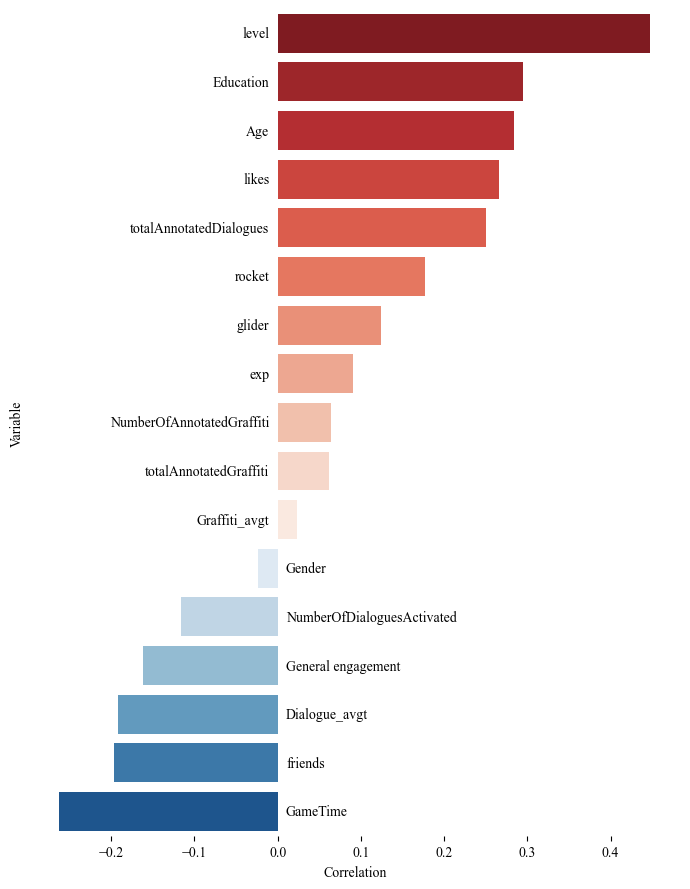

In [356]:
corr_matrix = X1[cols + categorical]
corr_matrix.loc[:,'cluster'] = sclabels
corr_matrix = corr_matrix.corr()
corr_target = corr_matrix.iloc[:-1,-1]
print('Linear correlation (feature -> cluster):')
print(f'Keep in mind: these correlations indicate the correlation of each feature to the cluster of the observations;\nClusters are artificially constructed categories that are numerically ordered on several features.')
print()
plot_correlations_with_cluster(corr_target)

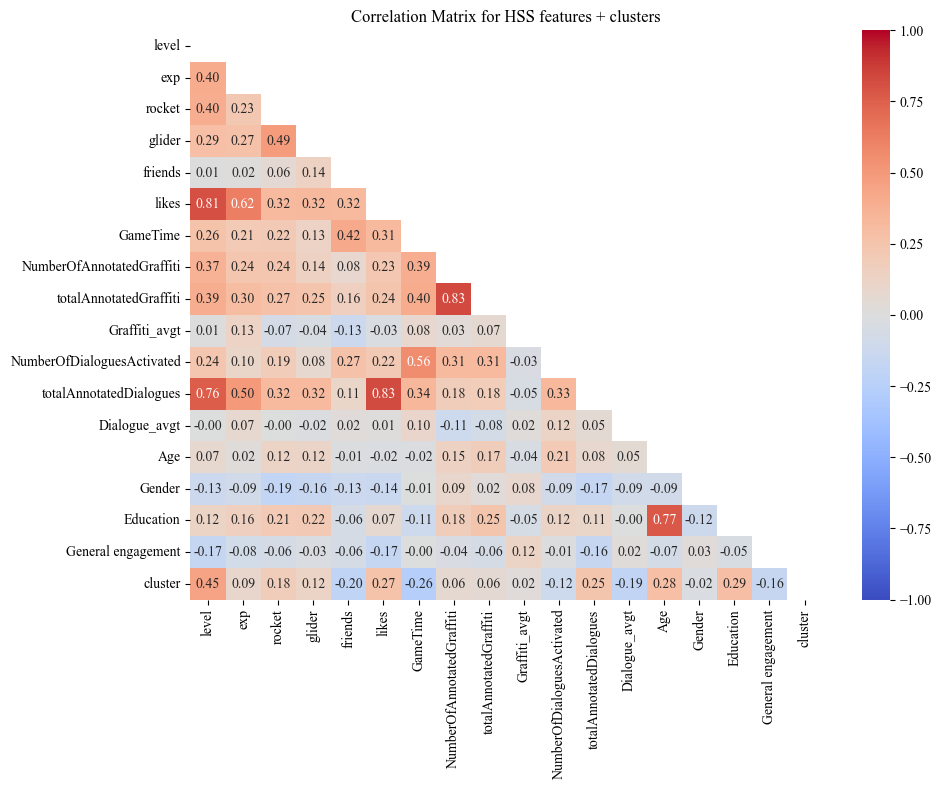

In [357]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix for HSS features + clusters')
plt.tight_layout()
plt.savefig('Graphs/Correlation_Matrix_for_HSS_features_plus_clusters.png', dpi= 500)
plt.show()

In [358]:
corr_matrix['cluster'].abs().sort_values(ascending=False)   #in Absolute values - to account for negative correlations remove .abs()

cluster                       1.000000
level                         0.447852
Education                     0.294737
Age                           0.284302
likes                         0.265355
GameTime                      0.262584
totalAnnotatedDialogues       0.249818
friends                       0.196704
Dialogue_avgt                 0.192253
rocket                        0.176901
General engagement            0.161421
glider                        0.124500
NumberOfDialoguesActivated    0.115674
exp                           0.090898
NumberOfAnnotatedGraffiti     0.064476
totalAnnotatedGraffiti        0.061471
Graffiti_avgt                 0.023618
Gender                        0.023592
Name: cluster, dtype: float64

## Modelling behaviour
In the High School Superhero game, a user could choose to play it "by the rules", effectively reducing the harmful dialogues and erasing graffiti (which require crystal collection, the game's currency), or something else such as just exploring the map or riding a scooter on a ramp. From the data, we may know what the user did based on the stats at the end of the gameplay.

I have previously displayed the correlations between each feature with the clusters, but what differs for these relationships in terms of strength when we model the features to predict the cluster? 


In [824]:
df[cols + categorical]

,level,exp,rocket,glider,friends,likes,GameTime,NumberOfAnnotatedGraffiti,totalAnnotatedGraffiti,Graffiti_avgt,NumberOfDialoguesActivated,totalAnnotatedDialogues,Dialogue_avgt,Age,Gender,Education,General engagement
0,1,40.0,False,False,2.0,100.0,1329.920044,12,7,0.767007,14,4,1.206215,13,0.0,0.0,4.0
1,1,0.0,False,False,3.0,150.0,1535.568115,4,2,0.818417,46,23,0.708021,13,0.0,0.0,4.0
2,1,40.0,False,False,0.0,0.0,1330.801025,3,3,0.000000,16,0,0.000000,13,0.0,0.0,3.0
3,1,0.0,False,False,4.0,200.0,1055.867920,0,0,0.000000,73,23,10.512301,13,0.0,0.0,2.0
4,1,0.0,False,False,2.0,100.0,633.536987,0,0,0.000000,15,8,1.205169,13,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,3,82.0,True,True,0.0,228.0,1079.027222,7,7,0.708955,23,30,0.862010,15,0.0,1.0,4.0
306,2,47.0,False,False,0.0,64.0,787.119995,17,8,0.563089,24,8,0.849623,15,0.0,1.0,2.0
307,2,59.0,False,False,1.0,154.0,899.514099,8,6,0.603374,19,10,1.338784,15,0.0,1.0,0.0
308,2,55.0,False,False,2.0,256.0,998.365051,0,0,0.000000,10,17,0.993167,14,0.0,1.0,2.0


In [858]:
# If you later select "g" you will visualize all observations.
g = df[cols + categorical].copy(deep=True)
g.loc[:,'cluster'] = sclabels
#     (scaled version of g)
X1_g = X1.copy()
X1_g['cluster'] = sclabels

# If you later select "centroids" you will visualize the centroids for each cluster, as a summary of the cluster.
centroid_df = g.copy(deep=True)
centroids = dict()
for cluster in set(sclabels):
    centroids[cluster] = centroid_df[centroid_df.cluster == cluster][cols + categorical].median()
centroids = pd.DataFrame.from_dict(centroids).T.reset_index().rename(columns={'index':'cluster'})
#     (scaled version of centroids)
X1centroid_df = X1_g.copy(deep=True)
X1centroids = dict()
for cluster in set(sclabels):
    X1centroids[cluster] = X1centroid_df[X1centroid_df.cluster == cluster].median()      # The median is a choice of representation. If we were to use 
                                                                                         # kmeans maybe the mean could've been fine, but 
                                                                                         # the data does not seem to be distributed in a convex manner, and 
                                                                                         # the median, compared to mean, can be a better center of the distribution.
X1centroids = pd.DataFrame.from_dict(X1centroids).T
cluster_sizes = g.groupby('cluster').count().iloc[:,1].tolist()
#--------

# If you later select "top6" you can visualize the strongest 10 correlated features 
top10 = corr_target.abs().sort_values(ascending=False)[:10].index.tolist() 
top10.reverse()

# If you later select "features" you can visualize all features, regardless of their correlation.
features = ['General engagement', 'Gender', 'Education', 'Age', 'GameTime', 'NumberOfAnnotatedGraffiti', 'Graffiti_avgt', 'totalAnnotatedGraffiti', 'glider', 'rocket', 'NumberOfDialoguesActivated', 'Dialogue_avgt', 'totalAnnotatedDialogues', 'friends', 'exp','likes', 'level']


In [362]:
# fig = px.colors.qualitative.swatches()
# fig.show()

General engagement
rocket
Dialogue_avgt
friends
totalAnnotatedDialogues
GameTime
likes
Age
Education
level
Disclaimer: the "Cluster" and "Cluster size" feature were produced by clustering, not the other way around.


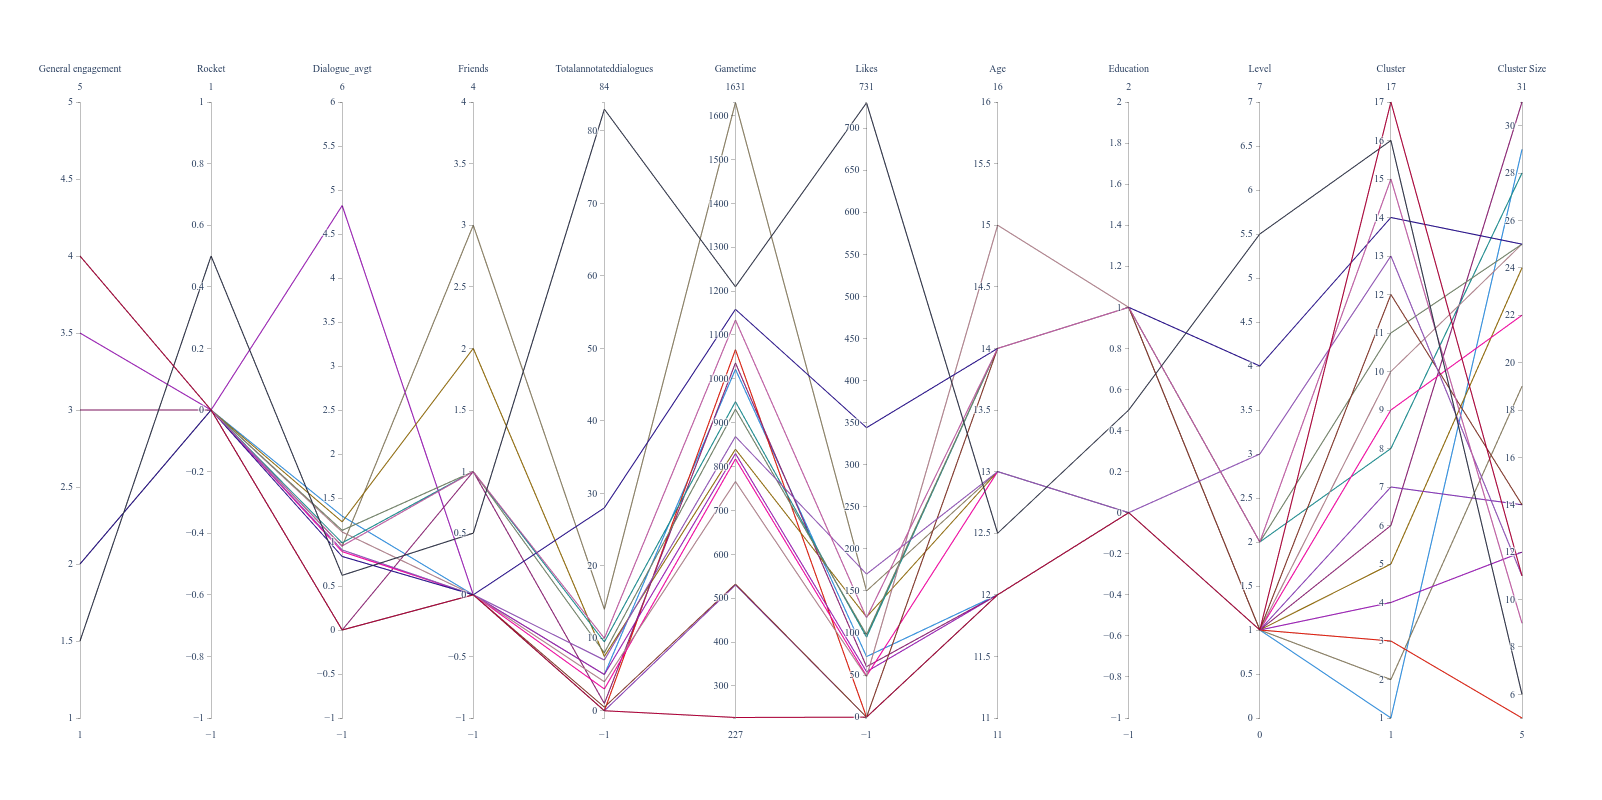

In [859]:
data = centroids.copy(deep=True) #this must be changed according to what dataframe you choose to display
amount_of_features = top10

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color=data['cluster'],   
                    colorscale = px.colors.qualitative.Dark24),
        #possible options for make_dict_for_parcoord can be: if you're displaying only centroids, I advise to also display the size of the clusters adding 
        # cluster sizes as the centroid_only parameter in the function
        dimensions = make_dict_for_parcoord(amount_of_features, data, cluster_sizes)   #cluster_sizes
    ))
w = 1250
h = 800
fig.update_layout(
    font=dict(
        family="Times New Roman"
    ),
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    width=w,
    height=h
)

# plotly.offline.plot(fig, filename='Graphs/Parallel_coordinates_HSS_.html')
print('Disclaimer: the "Cluster" and "Cluster size" feature were produced by clustering, not the other way around.')
fig.show()

I would like to point out a pattern that is an intuitive way to understand the spectral clustering results. 

For each of the first clusters, the median game scores are overall average compared to the whole centroid distribution. As we get closer to 17, each centroid indicates values further from the average, until we get to **16** and **17**'s values which are absolutely the **highest and lowest values** overall. The pattern in question is that the spectral clustering started assigning labels to observations that were the most around the center of the distributions, and started building outwards the other discretizations of the users. 

To better compare, we may visualize it in a way where distance is not to the scale it was originally created, but all features are around the range of values. This is the reason why some scales go below 0.

General engagement
rocket
Dialogue_avgt
friends
totalAnnotatedDialogues
GameTime
likes
Age
Education
level


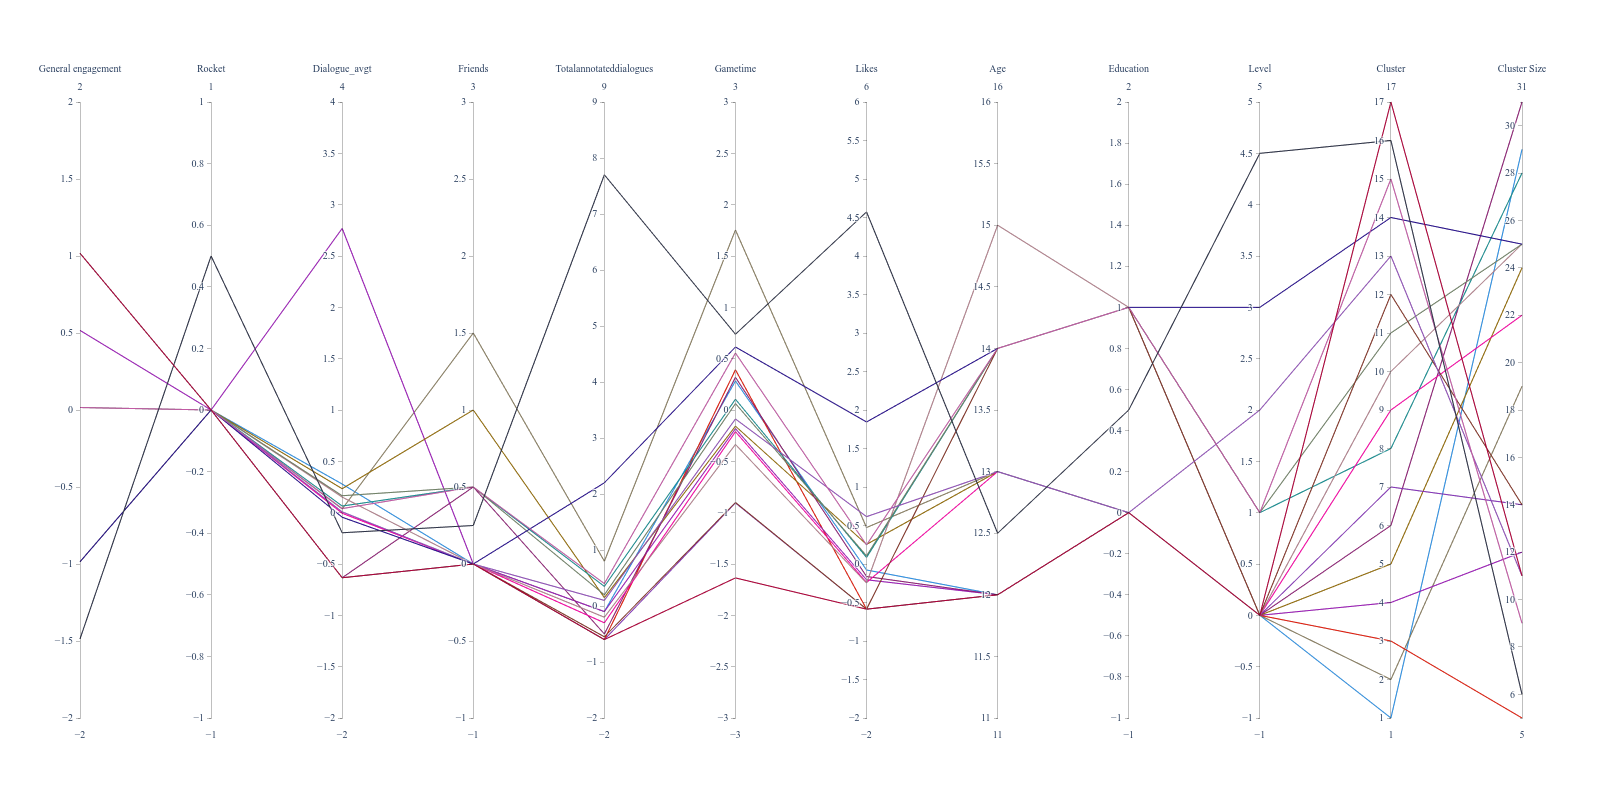

In [860]:
data = X1centroids #this must be changed according to what dataframe you choose to display
amount_of_features = top10

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color=data['cluster'],   #this must be changed according to what dataframe you chooe later in make_dict_for_parcoord
                    colorscale = px.colors.qualitative.Dark24),
        #possible options for make_dict_for_parcoord can be: 
        # AS LIST OF FEATURES TO DISPLAY: between [top10, list_of_features]
        # AS THE WHOLE DATAFRAME OR JUST THE CENTROIDS: between [centroids (or its scaled version, X1centroids), g (or its scaled version, X1_g)]
        dimensions = make_dict_for_parcoord(amount_of_features, data, cluster_sizes), 
    ))
w = 1300
h = 800
fig.update_layout(
    font=dict(
        family="Times New Roman"
    ),
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    width=w,
    height=h
)

# plotly.offline.plot(fig, filename='Graphs/Parallel_coordinates_HSS_centroids.html')
fig.show()

In [365]:
corr_target.sort_values()

GameTime                     -0.262584
friends                      -0.196704
Dialogue_avgt                -0.192253
General engagement           -0.161421
NumberOfDialoguesActivated   -0.115674
Gender                       -0.023592
Graffiti_avgt                 0.023618
totalAnnotatedGraffiti        0.061471
NumberOfAnnotatedGraffiti     0.064476
exp                           0.090898
glider                        0.124500
rocket                        0.176901
totalAnnotatedDialogues       0.249818
likes                         0.265355
Age                           0.284302
Education                     0.294737
level                         0.447852
Name: cluster, dtype: float64

Mutual information measures the dependency between two variables. I am using it in this case to see if the non-linear relationship can be analyzed by scoring each feature with the clusters, which are treated like categories (which is different from linear correlations, in which clusters are treated as an ordinal variable).

In [366]:

results = mutual_info_classif(df[cols + categorical], sclabels, discrete_features='auto')
pd.DataFrame({'feature':cols+categorical, 'mutual_info_classif':results}).set_index('feature').sort_values(by='mutual_info_classif', ascending=False)

,mutual_info_classif
feature,
level,0.525059
likes,0.505253
Graffiti_avgt,0.475205
totalAnnotatedDialogues,0.473810
GameTime,0.358310
NumberOfDialoguesActivated,0.353920
totalAnnotatedGraffiti,0.347977
Dialogue_avgt,0.338133
NumberOfAnnotatedGraffiti,0.336472


Some of these feature are mechanically dependent (in the sense of game mechanics) on other features and are highly linearly correlated. To make space in this research for a leaner analysis and less redundant variables, we may inspect using mutual information only the features that are not mechanically correlated. 

In [367]:
abs_corr = corr_matrix.abs()   #correlation matrix in absolute values
print('highly correlated features:')
already_seen = []

for c in abs_corr.columns:
    res = abs_corr[abs_corr[c] > 0.6].sort_values(by=c, ascending=False).index.tolist()[1:]
    if res:
        
        print()
        print(c)
        print(res, abs_corr[abs_corr[c] > 0.6].sort_values(by=c, ascending=False)[c].values.tolist()[1:])
        already_seen.extend(res)

highly correlated features:

level
['likes', 'totalAnnotatedDialogues'] [0.8056010456696265, 0.7598659274269907]

exp
['likes'] [0.6177271642942213]

likes
['totalAnnotatedDialogues', 'level', 'exp'] [0.8252970832380012, 0.8056010456696265, 0.6177271642942213]

NumberOfAnnotatedGraffiti
['totalAnnotatedGraffiti'] [0.832137975210406]

totalAnnotatedGraffiti
['NumberOfAnnotatedGraffiti'] [0.832137975210406]

totalAnnotatedDialogues
['likes', 'level'] [0.8252970832380012, 0.7598659274269907]

Age
['Education'] [0.7737217450133991]

Education
['Age'] [0.7737217450133991]


- We can remove **"likes"** and **"level"**: by doing so, we have their alternate (in terms of collinearity) made up by "exp" and "totalAnnotatedDialogues" and remove collinearity between them (which was mediated by likes and level).

In the schema below I use $↔$ to indicate correlation between two variables that are on the side of the symbol and $↮$ to indicate absence of a high linear relationship between the two.

$exp ↔ likes ↔ totalAnnotatedDialogues$ 

becomes 

$exp ↮ totalAnnotatedDialogues$ 

And since there is a trio of highly correlated variables composed by

$likes ↔ totalAnnotatedDialogues ↔ level ↔ likes$             (it is on one line for simplicity of visualization, but it can be shaped as a triad)

We can remove level as well, counting on the fact that totalAnnotatedDialogues is highly correlated with it. 

- We can remove **NumberOfAnnotatedGraffiti** to keep totalAnnotatedGraffiti and match totalAnnotatedDialogues better.
- We shold remove **NumberOfDialoguesActivated** to match better the set of graffiti-related variables, and even though it is not highly correlated with totalAnnotatedDialogues we may consider one as the in-game equivalent of the other due to game mechanics. They are not strongly correlated because only a finished annotated dialogue would add onto the totalAnnotatedDialogues, but the users did not end many dialogoues.
- I am not eager to remove Age or **Education** as the two are not game-dynamics related, but I will only keep Age as it is more detailed to interpret the behaviour.

In [368]:
to_remove = ['level', 'likes', 'NumberOfAnnotatedGraffiti','NumberOfDialoguesActivated', 'Education']
to_keep = list(set(cols + categorical) - set(to_remove))
results = mutual_info_classif(df[to_keep], sclabels, discrete_features='auto')
pd.DataFrame({'feature':to_keep, 'mutual_info_classif':results}).set_index('feature').sort_values(by='mutual_info_classif', ascending=False)

,mutual_info_classif
feature,
Graffiti_avgt,0.494186
totalAnnotatedDialogues,0.481747
totalAnnotatedGraffiti,0.384510
GameTime,0.358230
Dialogue_avgt,0.333120
Age,0.325221
General engagement,0.296877
Gender,0.273942
friends,0.196395


### Attempt: explainable machine learning using SHAP
In this section I want to perform SHapely Addivite exPlanations on the self-tuned spectral clustering model. Spectral clustering does belong to machine learning techniques, however, it is not one of the objects covered by SHAP project (and its python module), which is useful to explain how or why a certain model reached a set of outputs. 

The attempt in question is to reproduce the same results from spectral clustering using the labels produced as target but using other methods. The assumption is that the data is separable from multiple methods other than the clustering method. The objectives for this section are:

1. At least one tuned model that is as sensible to the data as the self-tuning spectral clustering
2. The tuned model is able to reach 100% accuracy from test set evaluation

The models that are tuned are decision trees, random forest classifier, K nearest neighbours and finally a multi-layer perceptron. 
<!-- The data is divided between train and test set. -->

In [50]:
import shap
import sklearn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [1]:
raise Exception('This section was not meant to be ran altogether with the rest as it requires excessive computation.')

Exception: This section was not meant to be ran altogether with the rest as it requires excessive computation.

In [ ]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X1, sclabels)

explainer = shap.KernelExplainer(knn.predict_proba, X1)
# shap_values = explainer.shap_values(X1)
# shap.summary_plot(shap_values, X1)

X_train, X_test, Y_train, Y_test = train_test_split(
    X1, sclabels, test_size=0.2, random_state=0
)

def print_accuracy(f):
    print(f"Accuracy = {100 * np.sum(f(X_test) == Y_test) / len(Y_test):.2f}%")

print_accuracy(knn.predict)

shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test)


In [ ]:
linear_lr = sklearn.linear_model.LogisticRegression(solver="newton-cg")
linear_lr.fit(X_train, Y_train)
print_accuracy(linear_lr.predict)

dtree = sklearn.tree.DecisionTreeClassifier(min_samples_split=2)
dtree.fit(X_train, Y_train)
print_accuracy(dtree.predict)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(
    n_estimators=100, max_depth=None, min_samples_split=2, random_state=0
)
rforest.fit(X_train, Y_train)
print_accuracy(rforest.predict)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
nn = MLPClassifier(solver="lbfgs", alpha=1e-1, hidden_layer_sizes=(138, 7), random_state=25, max_iter=100000) 
nn.fit(X_train, Y_train)
print_accuracy(nn.predict)

In [ ]:
shap.initjs()
explainer = shap.KernelExplainer(nn.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test)

### Interpretation of cluster results
The top three most positively and linearly correlated variables are *"level"*, *"Education"* and *"Age"*. The top three most negatively and linearly correlated variables are *GameTime*, *Friends* and *Average dialogue time*. However, based on the associations from mutual information

Simply based on the visualization, we will further inspect the composition of the clusters with more attention.

In [373]:
only_q = list(set(q_data.columns) - set(df.columns) ) + categorical + ['UserID']
only_q.sort()

In [374]:
gen_df = pd.merge(df[['UserID'] + cols], q_data[only_q], on='UserID', how='inner')  #creating a general dataframe, with clusters, questionnaire data and behavioural data.
gen_df.columns

Index(['UserID', 'level', 'exp', 'rocket', 'glider', 'friends', 'likes',
       'GameTime', 'NumberOfAnnotatedGraffiti', 'totalAnnotatedGraffiti',
       'Graffiti_avgt', 'NumberOfDialoguesActivated',
       'totalAnnotatedDialogues', 'Dialogue_avgt', 'Age', 'Creender',
       'Creender appropriateness', 'Education', 'FTSA1', 'FTSA2', 'FTSA3',
       'FTSA4', 'FTSA5', 'FTSA6', 'FTSC1', 'FTSC2', 'FTSC3', 'FTSC4', 'FTSC5',
       'FTSC6', 'Gender', 'General engagement', 'HSS', 'HSS appropriateness',
       'IMI-IE1', 'IMI-IE2', 'IMI-IE3', 'IMI-IE4', 'IMI-IE5', 'IMI-IE6',
       'IMI-IE7', 'IMI-PC1', 'IMI-PC2', 'IMI-PC3', 'IMI-PC4', 'IMI-PC5',
       'IMI-PC6', 'IMI-VU1', 'IMI-VU2', 'IMI-VU3', 'IMI-VU4', 'IMI-VU5',
       'IMI-VU6', 'IMI-VU7', 'RC', 'RC appropriateness', 'Recommendations',
       'Relationship with researchers', 'cluster'],
      dtype='object')

The plot is ordered based on the ascending count of "Femmina" inside of the cluster.


<Figure size 1600x1600 with 0 Axes>

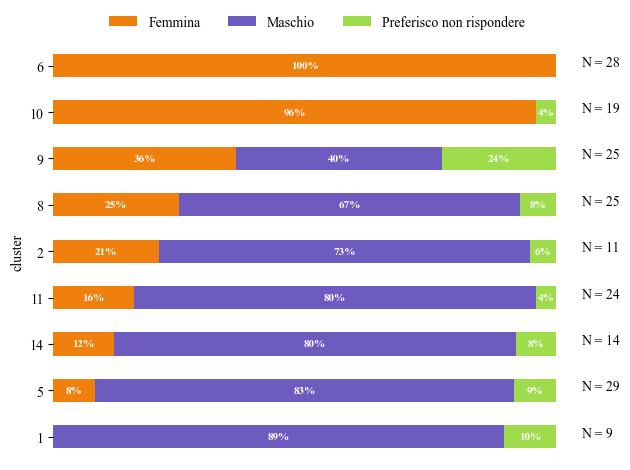

In [861]:
threshold = 15    # set a threshold to decide how big the clusters have to be to be visualized; the smaller threshold, the smaller the statistical power.
                                                                                     # Process:
grouped_df = q_data.groupby(['cluster'])['Gender'].value_counts().reset_index()      # - group by cluster and gender

grouped_df = grouped_df.pivot(index='cluster', columns='Gender', values='count').fillna(0)   # - make modalities of "Gender" as columns and as values the counts
 
grouped_df['total_count'] = grouped_df.sum(axis=1).astype(int)        # - sum over the cluster for the whole N

for gender in ['Femmina', 'Maschio', 'Preferisco non rispondere']:
    grouped_df[gender] = grouped_df[gender] / grouped_df['total_count']    # - for each of gender modalities and (implicitly) each cluster, compute relative frequency wtr to the N of cluster

grouped_df = grouped_df.sort_values(by=['Femmina', 'Preferisco non rispondere'])
frequencies = grouped_df[['Femmina', 'Maschio', 'Preferisco non rispondere']]   # - only select these columns for visualization

print('The plot is ordered based on the ascending count of "Femmina" inside of the cluster.')
plot_gender_comp(frequencies[grouped_df['total_count'] >= threshold], N_labels= grouped_df.total_count.tolist())

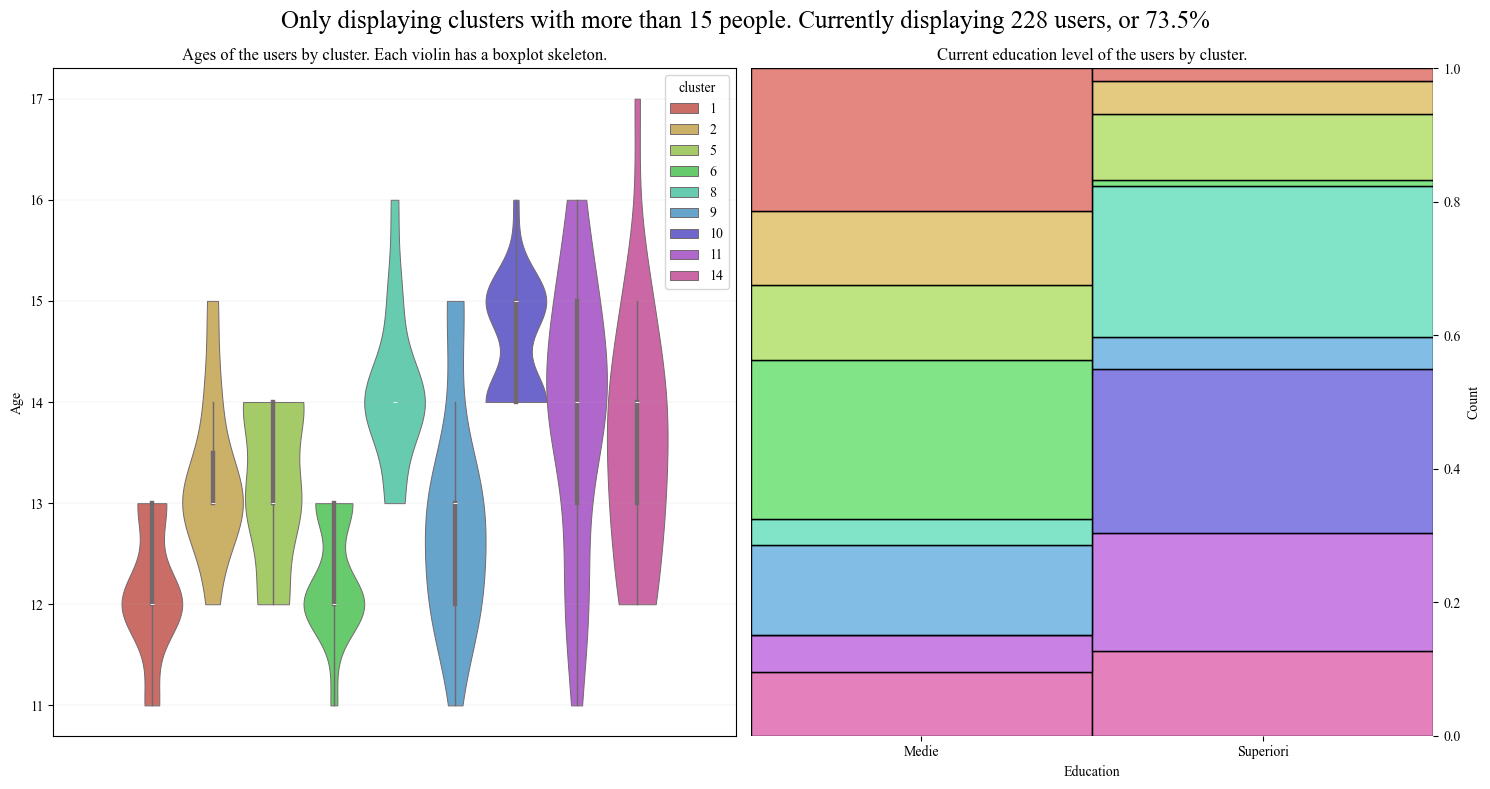

In [539]:

fig, axs = plt.subplots(1,2, figsize=(15, 8)) 
threshold = 15
g =  gen_df[gen_df.cluster.isin(grouped_df[grouped_df.total_count >= threshold].index.tolist())]

K = g.cluster.unique().shape[0]

sns.violinplot(data=g, hue='cluster', y='Age', cut=0, 
               palette = sns.color_palette('hls', K),
              linewidth=0.7,
              linecolor='#73686c', ax=axs[0])
axs[0].set_title('Ages of the users by cluster. Each violin has a boxplot skeleton.')
axs[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
axs[0].grid(axis='y', linewidth=0.1)

axs[1].set_title('Current education level of the users by cluster.')
sns.histplot(data=g, x='Education', hue='cluster', multiple='fill', ax=axs[1], palette=sns.color_palette('hls', K), legend=False)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

plt.suptitle(f'Only displaying clusters with more than {threshold} people. Currently displaying {g.shape[0]} users, or {100*(g.shape[0] / df.shape[0]):.1f}%', fontsize=18)
plt.box(False)
fig.tight_layout()
plt.savefig('Graphs/Age_distribution_by_cluster.png', dpi=500)
plt.show()

Clusters that belong mostly or completely to "Superiori" level education or aged 14 and more are: 8, 10. 

Clusters that belong mostly or completely to "Medie" level education or aged 13 and less are: 1, 6. 

The remainder (11, 14) are split between the two levels of education, but slightly leaning more onto "Superiori". 

In [588]:
centroids

,cluster,level,exp,rocket,glider,friends,likes,GameTime,NumberOfAnnotatedGraffiti,totalAnnotatedGraffiti,Graffiti_avgt,NumberOfDialoguesActivated,totalAnnotatedDialogues,Dialogue_avgt,Age,Gender,Education,General engagement
0,1,1.0,59.0,0.0,0.0,0.0,72.0,1021.620056,8.0,5.0,0.767007,14.0,5.0,1.294006,12.0,0.0,0.0,4.0
1,2,1.0,40.0,0.0,0.0,3.0,150.0,1629.801025,10.0,6.0,0.605882,46.0,14.0,0.949748,13.0,0.0,0.0,4.0
2,3,1.0,20.0,0.0,0.0,0.0,0.0,1066.638916,3.0,1.0,0.000000,4.0,0.0,0.000000,12.0,2.0,0.0,4.0
3,4,1.0,58.0,0.0,0.0,0.0,54.0,829.590515,3.0,3.0,0.621211,16.0,5.0,4.823260,12.0,0.0,0.0,3.5
4,5,1.0,36.0,0.0,0.0,2.0,119.0,839.546478,1.0,1.0,0.000000,14.0,7.5,1.229364,13.0,0.0,0.0,2.0
5,6,1.0,23.0,0.0,0.0,1.0,60.0,1036.207153,8.0,5.0,0.836715,19.0,1.0,0.000000,12.0,2.0,0.0,4.0
6,7,1.0,12.0,0.0,0.0,0.0,0.0,530.185516,3.0,2.0,0.000000,4.0,0.0,0.000000,12.0,2.0,0.0,2.0
7,8,2.0,45.0,0.0,0.0,1.0,95.0,947.954010,12.0,8.0,0.570763,23.5,9.5,0.990090,14.0,0.0,1.0,2.0
8,9,1.0,56.0,0.0,0.0,0.0,49.0,817.389465,4.0,3.0,2.403817,7.5,3.0,0.890406,13.0,1.0,0.0,4.0
9,10,1.0,72.0,0.0,0.0,0.0,48.0,765.843018,8.0,5.0,0.709758,10.0,4.0,1.113707,15.0,2.0,1.0,3.0


General engagement
Gender
Education
Age
GameTime
NumberOfAnnotatedGraffiti
Graffiti_avgt
totalAnnotatedGraffiti
glider
rocket
NumberOfDialoguesActivated
Dialogue_avgt
totalAnnotatedDialogues
friends
exp
likes
level


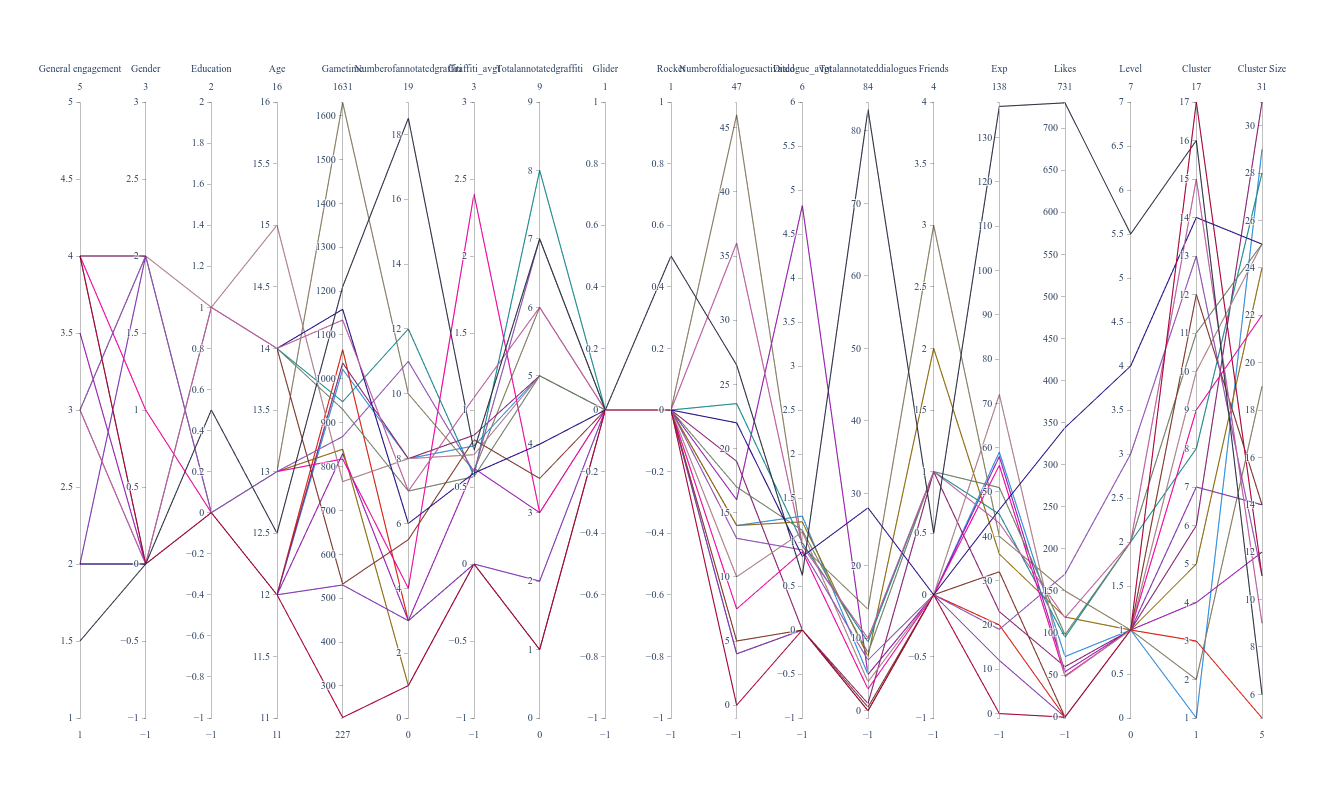

In [654]:
threshold = 40
data = centroids[~centroids.cluster.isin([])]
amount_of_features = features

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color=data['cluster'],   #this must be changed according to what dataframe you chooe later in make_dict_for_parcoord
                    colorscale = px.colors.qualitative.Dark24),
        #possible options for make_dict_for_parcoord can be: 
        # AS LIST OF FEATURES TO DISPLAY: between [top10, list_of_features]
        # AS THE WHOLE DATAFRAME OR JUST THE CENTROIDS: between [centroids (or its scaled version, X1centroids), g (or its scaled version, X1_g)]
        dimensions = make_dict_for_parcoord(amount_of_features, data, cluster_sizes), 
    ))
w = 1800
h = 800
fig.update_layout(
    font=dict(
        family="Times New Roman"
    ),
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    width=w,
    height=h
)

# plotly.offline.plot(fig, filename='Graphs/Parallel_coordinates_HSS_centroids.html')
fig.show()

### Human Labels
I propose some criteria to make a macro-category of clusters, each with their own characteristics but similar in a specified sense. 

While the criteria to assign them is an attempt for an objective and reasonable assignment, the names for the clusters are meant to be references to the most notable features for a cluster. Eventually, some clusters are more remarkable than other depending on how average or how extreme their in-game behaviour is. 

The following categories are **mutually exclusive and hierarchical**, meaning that if a cluster could fulfill both criteria #1 and #2, it is assigned to criteria #1. This is due to a choice of priority: some features are more important than others for clustering. In other words, in the scenario of stating "highest" or "lowest" score as the criterion for a macro-category, the first cluster with the highest or lowest score that hasn't been assigned to something *yet* will be assigned.

1. ***Bug finders / Cercatrici e cercatori di bug***
- Highest scores in _level_ and _exp_ and have activated at least the _rocket_ or the _glider_. 

Under this criteria, there is only cluster **16** with 6 people, usually exceeding by far the average number of dialogue and graffiti removal, maximizing the level and exp. 

2. ***Casual gamers / Gamers disinvolte/i***
- Lowest scores in _level_ and _exp_.

Under this criteria, there are cluster **17**  and **3** (11 and 5 people) that behave with the lowest scores in almost every game feature. The biggest difference is that cluster 3 played slightly more with graffiti and dialogues, while 17 never interacted with any dialogue. 

3. ***Talkers / Chiaccherone/i***
- Highest scores in _Number of annotated Dialogues_ and its "full version", _total annotated Dialogues_ (comparison highest between clusters)
- Regarding their whole gameplay dialogue-related behaviour has the highest scores (comparison highest between the cluster's own performance)

In this case, we can see from the parallel coordinates plot that clusters **15** and **2** (9 and 19 people) have the highest scores and behave similarly with other features, excluding the categorical ones. Cluster 2 also has the highest amount of friends made, likely in the context of dialogues.

4. ***House painters / Imbianchine/i***
- Highest scores in _Number of annotated Graffiti_ and its "full version", _total annotated Graffiti_ (comparison highest between clusters)
- Regarding their whole gameplay graffiti-related behaviour has the highest scores (comparison highest between the cluster's own performance)

Once again, excluding already labelled clusters, we can note that clusters **13** and **8** (11 and 28 people) are behaving similarly in terms of graffiti-related behaviour, but differ in terms of dialogue behaviour (only cluster 8 has interacted with dialogues, even slightly more than average). Differently from #13 and #8, clusters **12** and **10** have put little time into dialogues and most of their effort into graffiti

5. ***Cautious gamers / Gamers caute/i***
- Slowest times for removing graffiti / interacting with dialogues (both features that end in _avgt).

Cluster **9** for slowest graffiti removal and cluster **4** dialogue interaction are by far the slowest users (22 and 12 people). Disclaimer: the average time variable is computed accordingly to the mean time used while interacting with the in-game option, which could be representative of the whole image or simply the fact that the first time they interacted they took a long time to play and never played again. With this in consideration, their times are still slower than most.

6. ***Distant viewers / Osservatori esterni***
- Lowest engagement, inconsistent scores for most of the features.

Clusters **14**, **7**, **5** (25, 14 and 24 people) fall in this broader category. The only thing that summarizes them is that they reported not enjoying the game, for reasons we will investigate, even though cluster 14 had some above average scores. There is also a gender difference: cluster 7 is mostly "Femmine", while the other two are mostly "Maschi". 

7. ***Fans / Fans***
- Highest engagement, average scores for most of the features.

Clusters **11**, **6** and **1** (25, 31 and 29 people) have reported a high engagement with the game. Overall, they have scored right on average compared to all the other clusters. 

In [747]:
macro_categories = {
    1:'Fans',
    2:'Talkers',
    3:'Casual gamers',
    4:'Cautious gamers',
    5:'Distant viewers',
    6:'Fans',
    7:'Distant viewers',
    8:'House painters',
    9:'Cautious gamers',
    10:'House painters',
    11:'Fans',
    12:'House painters',
    13:'House painters',
    14:'Distant viewers',
    15:'Talkers', 
    16:'Bug finders', 
    17:'Casual gamers'
}
macro_categories_it = {
    1:'Fans',
    2:'Chiaccherone/i',
    3:'Gamers disinvolte/i',
    4:'Gamers caute/i',
    5:'Osservatori esterni',
    6:'Fans',
    7:'Osservatori esterni',
    8:'Imbianchine/i',
    9:'Gamers caute/i',
    10:'Imbianchine/i',
    11:'Fans',
    12:'Imbianchine/i',
    13:'Imbianchine/i',
    14:'Osservatori esterni',
    15:'Chiaccherone/i', 
    16:'Cercatrici e cercatori di bug', 
    17:'Gamers disinvolte/i'   
}

In [912]:
human_labelled = gen_df.copy()
human_labelled.loc[:,'cluster'] = [macro_categories[c] for c in human_labelled.cluster]
X1_g['cluster'] = [macro_categories[c] for c in X1_g.cluster]
centroids.loc[:,'cluster'] = [macro_categories[c] for c in centroids.cluster]
X1centroids.loc[:,'cluster'] = [macro_categories[c] for c in X1centroids.cluster]

KeyError: 'Fans'

In [901]:
dict(radialaxis_tickfont_size = 8, angularaxis = dict(tickfont_size=8,rotation=90, direction="counterclockwise")) 

{'radialaxis_tickfont_size': 8,
 'angularaxis': {'tickfont_size': 8,
  'rotation': 90,
  'direction': 'counterclockwise'}}

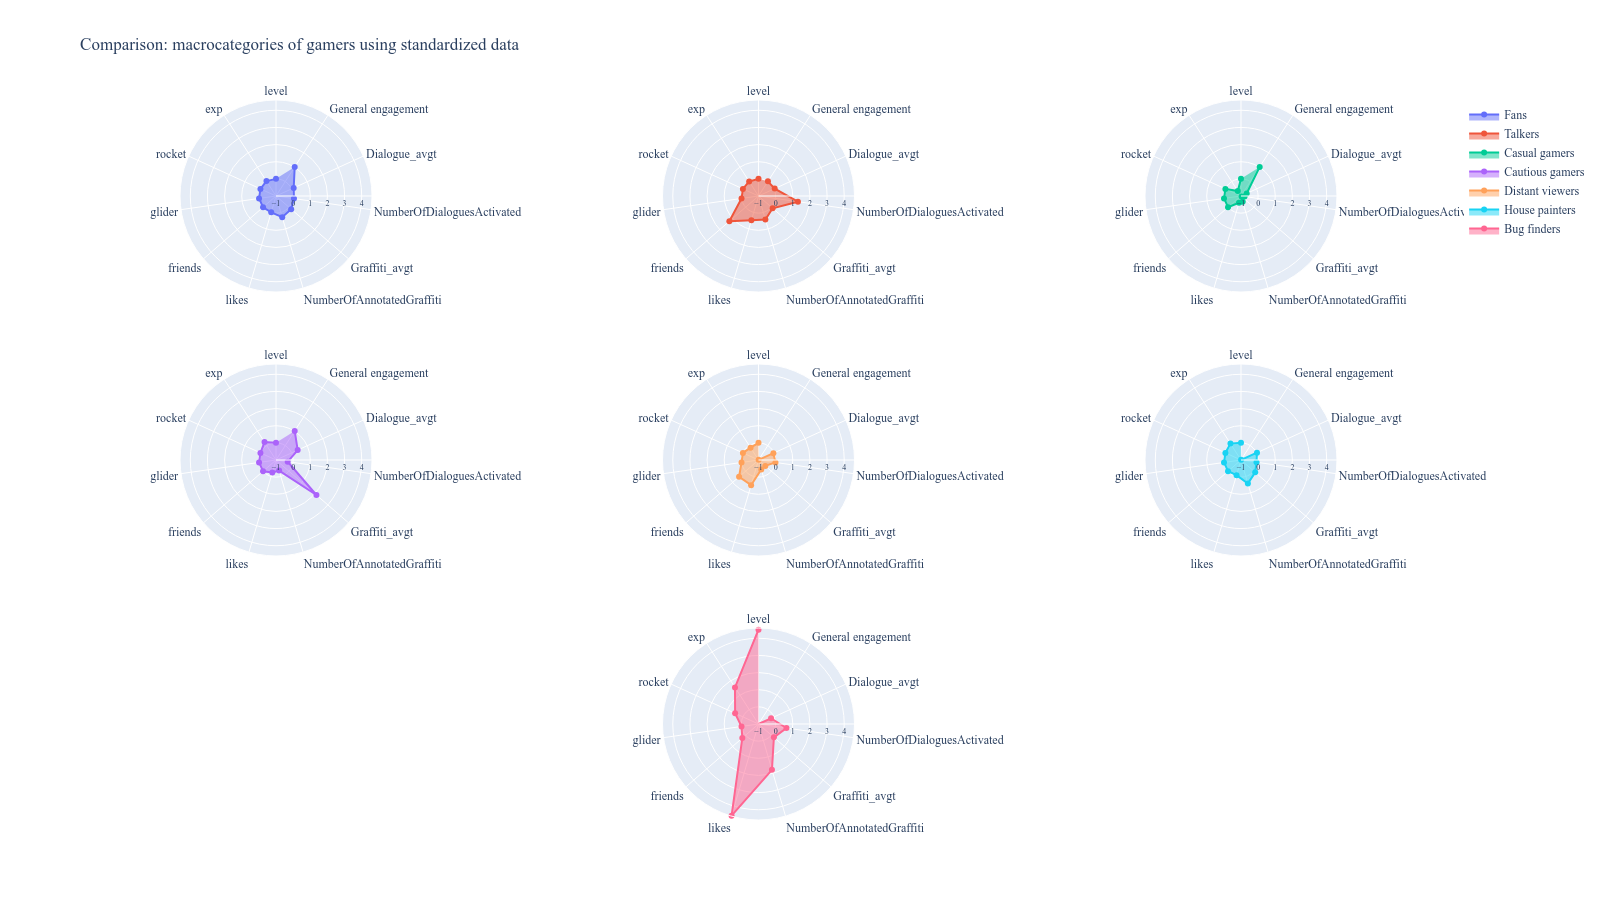

In [927]:
g = X1_g.copy(deep=True) #We can use scaled centroids or the whole scaled dataset (it's the same mean)
col_to_display = ['level', 'exp', 'rocket', 'glider', 'friends', 'likes', 'NumberOfAnnotatedGraffiti', 'Graffiti_avgt', 'NumberOfDialoguesActivated', 'Dialogue_avgt', 'General engagement']

r, c = 3, 3

fig = make_subplots(rows=r, cols=c, specs=[[{'type': 'polar'}]*3]*3)

clusters = X1centroids.cluster.unique().tolist()

track = 0
stop = False
for i in range(1, r + 1):
    for j in range(1, c + 1):
        if i == 3 and j == 1:
            j = 2
            stop = True
        name = clusters[track]
        
        fig.add_trace(
            go.Scatterpolar(
                name=name,
                r=X1_g[X1_g.cluster == name][col_to_display].median(),
                theta=col_to_display,
                fill='toself'
            ),
            row=i, col=j
        )

        
        fig.update_polars(
            radialaxis=dict(range=[-1, 4.6], tickfont_size=8),
            angularaxis=dict(tickfont_size=12, rotation=90, direction="counterclockwise"),
            row=i, col=j
        )
        
        track += 1
        if stop:
            break

fig.update_layout(
    title_text="Comparison: macrocategories of gamers using standardized data",
    width=1600,
    height=900, 
    font=dict(
        family="Times New Roman"
    ),
    
)
plotly.offline.plot(fig, filename='Graphs/Clusters_radialcharts.html')
fig.show()

The plot is ordered based on the ascending count of "Femmina" inside of the cluster.


<Figure size 1600x1600 with 0 Axes>

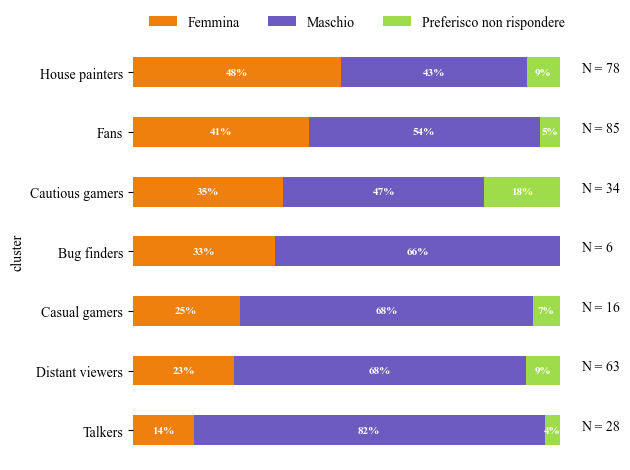

In [905]:
threshold = 0    # set a threshold to decide how big the clusters have to be to be visualized; the smaller threshold, the smaller the statistical power.
                                                                                     # Process:
grouped_df = human_labelled.groupby(['cluster'])['Gender'].value_counts().reset_index()      # - group by cluster and gender

grouped_df = grouped_df.pivot(index='cluster', columns='Gender', values='count').fillna(0)   # - make modalities of "Gender" as columns and as values the counts
 
grouped_df['total_count'] = grouped_df.sum(axis=1).astype(int)        # - sum over the cluster for the whole N

for gender in ['Femmina', 'Maschio', 'Preferisco non rispondere']:
    grouped_df[gender] = grouped_df[gender] / grouped_df['total_count']    # - for each of gender modalities and (implicitly) each cluster, compute relative frequency wtr to the N of cluster

grouped_df = grouped_df.sort_values(by=['Femmina', 'Preferisco non rispondere'])
frequencies = grouped_df[['Femmina', 'Maschio', 'Preferisco non rispondere']]   # - only select these columns for visualization

print('The plot is ordered based on the ascending count of "Femmina" inside of the cluster.')
plot_gender_comp(frequencies[grouped_df['total_count'] >= threshold], N_labels= grouped_df.total_count.tolist())

## Appendix / failed experiments
The following cells were previously used to compare groups from different clusters, but different clustering techniques were used then which means different results. I am keeping them for an easy access to their statistical tests, which can always come in handy.

In [906]:
gen_df[gen_df['cluster'].isin([16,17])].groupby(['General engagement', 'Gender']).median('Gender')

level    exp  rocket  \
General engagement     Gender                                            
Coinvolgente           Femmina                      4.5   15.0     0.0   
                       Maschio                      1.0    0.0     0.0   
Molto coinvolgente     Maschio                      1.0    0.0     0.0   
                       Preferisco non rispondere    1.0    0.0     0.0   
Piuttosto coinvolgente Maschio                      3.0   36.5     0.5   
Poco coinvolgente      Femmina                      5.0  165.0     0.0   
                       Maschio                      7.0  337.5     0.5   

                                                  glider  friends   likes  \
General engagement     Gender                                               
Coinvolgente           Femmina                       0.0      0.0   690.0   
                       Maschio                       0.0      0.0     0.0   
Molto coinvolgente     Maschio                       0.0      0.0     0.0   
                       Preferisco non rispondere     0.0      0.0     0.0   
Piuttosto coinvolgente Maschio                       0.5      0.0   260.0   
Poco coinvolgente      Femmina                       0.0      0.0   492.0   
                       Maschio                       0.5      1.5  1529.5   

                                                     GameTime  \
General engagement     Gender                                   
Coinvolgente           Femmina                     559.400405   
                       Maschio                     266.083496   
Molto coinvolgente     Maschio                     597.413025   
                       Preferisco non rispondere   294.946014   
Piuttosto coinvolgente Maschio                     614.686523   
Poco coinvolgente      Femmina                    1605.122925   
                       Maschio                    1124.226440   

                                                  NumberOfAnnotatedGraffiti  \
General engagement     Gender                                                 
Coinvolgente           Femmina                                         10.0   
                       Maschio                                          1.0   
Molto coinvolgente     Maschio                                          2.0   
                       Preferisco non rispondere                        0.0   
Piuttosto coinvolgente Maschio                                          7.5   
Poco coinvolgente      Femmina                                         22.0   
                       Maschio                                         12.0   

                                                  totalAnnotatedGraffiti  \
General engagement     Gender                                              
Coinvolgente           Femmina                                       3.5   
                       Maschio                                       1.0   
Molto coinvolgente     Maschio                                       2.0   
                       Preferisco non rispondere                     0.0   
Piuttosto coinvolgente Maschio                                       2.5   
Poco coinvolgente      Femmina                                      19.0   
                       Maschio                                      10.5   

                                                  Graffiti_avgt  ...  IMI-PC5  \
General engagement     Gender                                    ...            
Coinvolgente           Femmina                         0.410058  ...      5.0   
                       Maschio                         0.000000  ...      4.5   
Molto coinvolgente     Maschio                         0.000000  ...      5.0   
                       Preferisco non rispondere       0.000000  ...      4.0   
Piuttosto coinvolgente Maschio                         0.322800  ...      5.0   
Poco coinvolgente      Femmina                         0.497886  ...      6.0   
                       Maschio                         0.9

In [ ]:
colors = list(Color('#ba4dbf').range_to(Color("#ffb60f"), cl_df.cluster.unique().shape[0]))
colors = [str(color) for color in colors]
fig, axs = plt.subplots(1,2, figsize=(10, 5)) 

sns.histplot(data=gen_df, x='friends', hue='cluster', multiple='fill', palette=colors, binwidth=1, ax=axs[0], legend='topleft')
axs[0].set_title('Friends count, hued on cluster')

plt.tight_layout()
plt.savefig('Graphs/gametime_distribution_byAge_andGender.png', dpi=500)

Now the same concept applied between age and game time, also with gender inside of each violinplot.

In [ ]:
colors = list(Color('#ba4dbf').range_to(Color("#ffb60f"),7))
colors = [str(color) for color in colors]
plt.figure(figsize=(10, 8))
sns.violinplot(data=w[w.Gender != 'Preferisco non rispondere'], x='Age',y='GameTime', cut=0,
               hue='Gender',split=True,
               #palette=sns.color_palette(colors),
               linewidth=0.7,
               linecolor='#73686c')
plt.grid(axis='y', linewidth=0.4)
plt.box(False)
plt.legend(title='Genere')
plt.tight_layout()
plt.savefig('Graphs/gametime_distribution_byAge_andGender.png', dpi=500)

On average, 13 year old users were able to play for a handful of minutes more than everyone else. Is this result due to their ability to log in as soon as they got the computer and spend as much time as possible on the game (without mistakenly logging out)? Or is it due to environmental noise and sample size? We'll exclude the sample size doubt in a few computations.

In [ ]:
sns.barplot(w.Age.value_counts(), width=0.95)
plt.title('Age Distribution')
plt.margins(x=0.0)
plt.show()

In [ ]:
# Using the Central Limit Theorem, and assuming that the distribution of Game Time for each age is 
# identically distributed and independent from others, it's normal, and considering that each sample has size >= 30, I perform a comparison 
# between mean GameTime for age group = 12 and age group = 13. 
# To reduce the amount of assumptions, I also check for similar variance using Levene's test for equality of variances. 

stat_levene1213, p_value_levene1213 = levene(w[w.Age==12].GameTime, w[w.Age==13].GameTime)
stat_levene1314, p_value_levene1314 = levene(w[w.Age==13].GameTime, w[w.Age==14].GameTime)

t_statistic1213, p_value1213 = ttest_ind(w[w.Age==12].GameTime, w[w.Age==13].GameTime)
t_statistic1314, p_value1314 = ttest_ind(w[w.Age==13].GameTime, w[w.Age==14].GameTime)

In [ ]:
print(f'Comparing the mean GameTime between age groups. {color.BOLD}12{color.END} year olds played for {round(w[w.Age==12].GameTime.mean()//60)} minutes, while {color.BOLD}13{color.END} year olds played for {round(w[w.Age==13].GameTime.mean()//60)} minutes.')
print(f'P-value for Levene\'s test:{p_value_levene1213:.4f}')

print(f'Test Statistic: {color.BOLD}{t_statistic1213:.2f}{color.END}\nP-value for t-statistic: {color.BOLD}{p_value1213:.4f}{color.END}')
print()
print('When conducting the Levene\'s test, if the p-value > significance level, there is no significant difference \nin variances between two groups and the t-test may be conducted assuming equal variance.')
print('Instead, a small p-value for t-test indicates the difference is statistically significant and we should consider the mean between two groups different.')
print()
print(f'Comparing the mean GameTime between age groups. {color.BOLD}13{color.END} year olds played for {round(w[w.Age==13].GameTime.mean()//60)} minutes, while {color.BOLD}14{color.END} year olds played for {round(w[w.Age==14].GameTime.mean()//60)} minutes.')
print(f'P-value for Levene\'s test: {p_value_levene1314:.4f}')

print(f'Test Statistic: {color.BOLD}{t_statistic1314:.2f}{color.END}\nP-value for t-statistic: {color.BOLD}{p_value1314:.4f}{color.END}')

As we can tell from the tests, comparing 13 vs 12 year olds is significant and their variances can be assumed as equivalent. Comparing the 13 vs 14 unfortunately does not meet the variance assumption, but there are ways around this. 

In [ ]:
#Mann-Whitney U test is a non parametric test is used for the unmet variance assumption. 
u_statistic, p_value = mannwhitneyu(w[w.Age==13].GameTime,w[w.Age==14].GameTime)
print(f'U test: {color.BOLD}{u_statistic}{color.END}')
print(f'P-value: {color.BOLD}{p_value:.4f}{color.END}')
print('The U test is a non-parametric test used to assess whether two independent samples come from the same population or have the same distribution.\nWhen the p-value is small, the difference is statistically significant, and a high u-statistic is considered a high difference.')

Therefore, we have information: 13 year olds, in this sample, are significantly playing for longer than 12 and 15 year olds, and have the longest play time. 
Information about the tests used can be explained in several sources, as in [this example](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_nonparametric/bs704_nonparametric_print.html#:~:text=When%20comparing%20two%20independent%20samples,the%20Mann%20Whitney%20U%20test.).